In [1]:
import pyreadr
import pandas
import numpy
import random
from random import randrange
import array
import scipy
import sklearn.metrics.pairwise
import seaborn
import matplotlib.pyplot as plt

In [2]:
import sys
numpy.set_printoptions(threshold=sys.maxsize)
pandas.set_option('display.max_columns', None)  

In [3]:
result = pyreadr.read_r('day_stress_transposed')
day_stress_transposed = result[None]
##day_stress_transposed.iloc[108, :]
del day_stress_transposed["user_id"]
##number of columns is 34, 124 rows

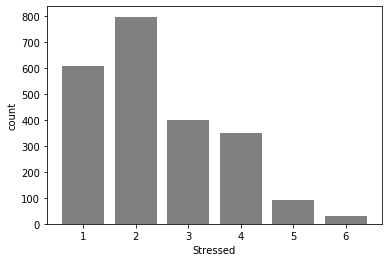

In [4]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(day_stress_transposed), return_counts=True)
plt.bar(u, c, color = "grey")
plt.xlabel('Stressed')
plt.ylabel('count')
fig.savefig("Stressed distr BMDI.pdf", bbox_inches='tight')

In [5]:
print(day_stress_transposed.isnull().sum().sum())

1941


In [6]:
null_rows = day_stress_transposed[day_stress_transposed.isnull().all(axis=1)]
null_rows

,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
##Remove index 45, 51, 81, 108 because only na's
day_stress_transposed = day_stress_transposed.drop(day_stress_transposed[day_stress_transposed.isnull().all(axis=1)].index)

In [8]:
## all rows having missing values in first and last column are replaced by row mean. Otherwise imputation method
##quadratic and cubic are not working!
day_stress_transposed_mean = day_stress_transposed.apply(lambda x: x.fillna(round(x.mean(), 0)),axis=1)
first_column_mean = day_stress_transposed_mean.iloc[:,0]
last_column_mean = day_stress_transposed_mean.iloc[:,-1]

In [9]:
day_stress_transposed.iloc[:,0] = first_column_mean
day_stress_transposed.iloc[:,-1] = last_column_mean

In [10]:
day_stress_na = (day_stress_transposed.isnull().sum(axis=1))

In [11]:
vals, counts = numpy.unique(day_stress_na, return_counts=True)
dic_day_stress_na = dict(zip(vals, counts))
dic_day_stress_na
##47 users that have 8 or less NA values on 34 rows

{1: 3,
 3: 2,
 4: 2,
 5: 5,
 6: 7,
 7: 13,
 8: 15,
 9: 10,
 10: 11,
 11: 4,
 12: 1,
 13: 6,
 14: 3,
 15: 3,
 16: 1,
 17: 5,
 18: 1,
 19: 1,
 20: 1,
 21: 2,
 22: 2,
 23: 2,
 25: 2,
 26: 1,
 27: 3,
 28: 4,
 29: 2,
 30: 5,
 31: 3}

In [12]:
#need to be 8 otherwise cubic is not working
day_stress_few_na = day_stress_transposed[day_stress_transposed.isnull().sum(axis=1) <= 8]
day_stress_few_na_copy = day_stress_few_na.copy()

In [13]:
day_stress_transposed_copy = day_stress_transposed.copy()

In [14]:
##randomly remove values
##pick random value in row and make it NA; store its value somewhere; do MDI on the forced NA's and calculate error on real value
##RUN ONLY ONCE OTHERWISE MORE VALUES GET REMOVED! > or get new copy again

random.seed(113)
day_stress_few_na_matrix = numpy.zeros((128, day_stress_few_na_copy.shape[1]))

for index, row in day_stress_few_na_copy.iterrows():
    row = numpy.array(row)
    random_index = randrange(len(row))
    z = row[random_index]
    while numpy.isnan(z):
        random_index = randrange(len(row))
        z = row[random_index]
    else:
        day_stress_few_na_copy.loc[index][random_index] = numpy.nan
        day_stress_few_na_matrix[index][random_index] = z   
##Matrix shows 115 rows: if array contains only 0's, the index is NOT in stress_few_na, so ignore!

In [15]:
day_stress_impute_mean = day_stress_few_na_copy.apply(lambda x: x.fillna(int(x.mean())),axis=1)
day_stress_impute_median = day_stress_few_na_copy.apply(lambda x: x.fillna(int(x.median())),axis=1)
day_stress_impute_linear = day_stress_few_na_copy.interpolate(method = "linear", limit_direction = "both")
day_stress_impute_quadratic = day_stress_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
day_stress_impute_cubic = day_stress_few_na_copy.interpolate(method = "cubic", limit_direction = "both")

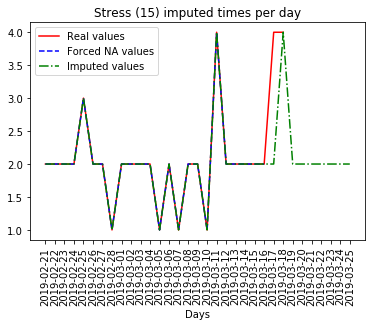

In [16]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_stress_few_na.iloc[0])
plt.plot(day_stress_few_na.iloc[15, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_stress_few_na_copy.iloc[15, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_stress_impute_median.iloc[15, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Days"),
       title='Stress (15) imputed times per day');
fig.savefig("Stress 15 imputed.pdf", bbox_inches='tight')

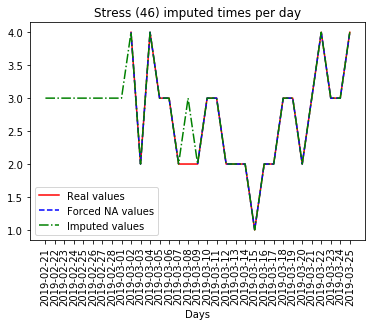

In [17]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_stress_few_na.iloc[0])
plt.plot(day_stress_few_na.iloc[46, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_stress_few_na_copy.iloc[46, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_stress_impute_median.iloc[46, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Days"),
       title='Stress (46) imputed times per day');
fig.savefig("Stress 46 imputed.pdf", bbox_inches='tight')

In [18]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_stress_few_na_matrix)):
    if numpy.all(day_stress_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_stress_few_na_matrix[array])[0]
        y = day_stress_few_na_matrix[array][y_index]
        w = day_stress_impute_mean.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[27.] [3.]
30.0


In [19]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_stress_few_na_matrix)):
    if numpy.all(day_stress_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_stress_few_na_matrix[array])[0]
        y = day_stress_few_na_matrix[array][y_index]
        w = day_stress_impute_median.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[15.] [10.]
25.0


In [20]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_stress_few_na_matrix)):
    if numpy.all(day_stress_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_stress_few_na_matrix[array])[0]
        y = day_stress_few_na_matrix[array][y_index]
        w = day_stress_impute_linear.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[30.25] [23.25]
53.5


In [21]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_stress_few_na_matrix)):
    if numpy.all(day_stress_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_stress_few_na_matrix[array])[0]
        y = day_stress_few_na_matrix[array][y_index]
        w = day_stress_impute_quadratic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[44.78590998] [25.70409675]
70.49000673011051


C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [22]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_stress_few_na_matrix)):
    if numpy.all(day_stress_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_stress_few_na_matrix[array])[0]
        y = day_stress_few_na_matrix[array][y_index]
        w = day_stress_impute_cubic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


[60.33408937] [25.6532707]
85.98736007264088


In [23]:
final_day_stress_impute_median = day_stress_transposed.apply(lambda x: x.fillna(round(x.median())),axis=1)

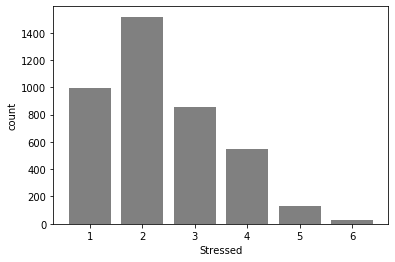

In [24]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(final_day_stress_impute_median), return_counts=True)
plt.bar(u, c, color = "grey")
plt.xlabel('Stressed')
plt.ylabel('count')
fig.savefig("Stressed distr AMDI.pdf", bbox_inches='tight')

In [25]:
##stress_few_na_copy1 = stress_few_na_copy.fillna(-1)

In [26]:
##stress_few_na_copy1.iloc[:3]

In [27]:
##Then apply best performing imputation method to full stress_transposed and do the other similarity python script
#for dataset in (stress_few_na_copy1, stress_impute_mean):
#    seaborn.lineplot(dataset)
##seaborn.lineplot(stress_few_na_copy1.iloc[:1])

In [28]:
result = pyreadr.read_r('day_calm_transposed')
day_calm_transposed = result[None]
del day_calm_transposed["user_id"]
##number of columns is 34, 114 rows

In [29]:
print(day_calm_transposed.isnull().sum().sum())

1941


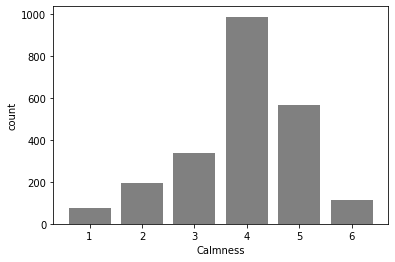

In [30]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(day_calm_transposed), return_counts=True)
plt.bar(u, c, color = "grey")
plt.xlabel('Calmness')
plt.ylabel('count')
fig.savefig("Calmness distr BMDI.pdf", bbox_inches='tight')

In [31]:
##index 45, 51, 81, 108 NA
day_calm_transposed = day_calm_transposed.drop(day_calm_transposed[day_calm_transposed.isnull().all(axis=1)].index)
print(day_calm_transposed.shape)

(120, 34)


In [32]:
## all rows having missing values in first and last column are replaced by row mean. Otherwise imputation method
##quadratic and cubic are not working!
day_calm_transposed_mean = day_calm_transposed.apply(lambda x: x.fillna(round(x.mean(), 0)), axis=1)
first_column_mean = day_calm_transposed_mean.iloc[:,0]
last_column_mean = day_calm_transposed_mean.iloc[:,-1]

In [33]:
day_calm_transposed.iloc[:,0] = first_column_mean
day_calm_transposed.iloc[:,-1] = last_column_mean

In [34]:
day_calm_na = (day_calm_transposed.isnull().sum(axis=1))

In [35]:
vals, counts = numpy.unique(day_calm_na, return_counts=True)
dic_day_calm_na = dict(zip(vals, counts))
dic_day_calm_na
##47 users that have 8 or less NA values on 34 rows

{1: 3,
 3: 2,
 4: 2,
 5: 5,
 6: 7,
 7: 13,
 8: 15,
 9: 10,
 10: 11,
 11: 4,
 12: 1,
 13: 6,
 14: 3,
 15: 3,
 16: 1,
 17: 5,
 18: 1,
 19: 1,
 20: 1,
 21: 2,
 22: 2,
 23: 2,
 25: 2,
 26: 1,
 27: 3,
 28: 4,
 29: 2,
 30: 5,
 31: 3}

In [36]:
#need to be 8 otherwise cubic is not working
day_calm_few_na = day_calm_transposed[day_calm_transposed.isnull().sum(axis=1) <= 8]
day_calm_few_na_copy = day_calm_few_na.copy()

In [37]:
day_calm_transposed_copy = day_calm_transposed.copy()

In [38]:
##randomly remove values
##pick random value in row and make it NA; store its value somewhere; do MDI on the forced NA's and calculate error on real value
##RUN ONLY ONCE OTHERWISE MORE VALUES GET REMOVED! > or get new copy again

random.seed(113)

day_calm_few_na_matrix = numpy.zeros((128, day_calm_few_na_copy.shape[1]))

for index, row in day_calm_few_na_copy.iterrows():
    row = numpy.array(row)
    random_index = randrange(len(row))
    z = row[random_index]
    while numpy.isnan(z):
        random_index = randrange(len(row))
        z = row[random_index]
    else:
        day_calm_few_na_copy.loc[index][random_index] = numpy.nan
        day_calm_few_na_matrix[index][random_index] = z   
##Matrix shows 115 rows: if array contains only 0's, the index is NOT in stress_few_na, so ignore!

In [39]:
day_calm_impute_mean = day_calm_few_na_copy.apply(lambda x: x.fillna(int(x.mean())),axis=1)
day_calm_impute_median = day_calm_few_na_copy.apply(lambda x: x.fillna(int(x.median())),axis=1)
day_calm_impute_linear = day_calm_few_na_copy.interpolate(method = "linear", limit_direction = "both")
day_calm_impute_quadratic = day_calm_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
day_calm_impute_cubic = day_calm_few_na_copy.interpolate(method = "cubic", limit_direction = "both")

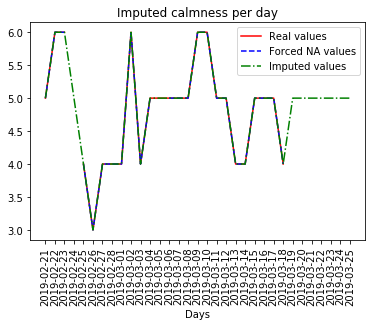

In [40]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_times_few_na.iloc[0])
plt.plot(day_calm_few_na.iloc[14, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_calm_few_na_copy.iloc[14, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_calm_impute_median.iloc[14, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Days"),
       title='Imputed calmness per day');
fig.savefig("Calmness 14 imputed.pdf", bbox_inches='tight')

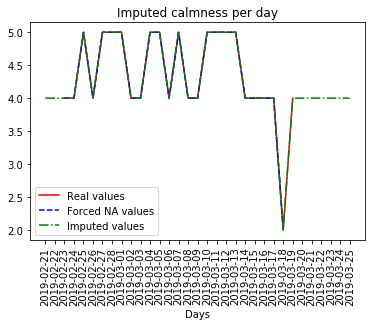

In [41]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_times_few_na.iloc[0])
plt.plot(day_calm_few_na.iloc[25, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_calm_few_na_copy.iloc[25, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_calm_impute_median.iloc[25, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Days"),
       title='Imputed calmness per day');
fig.savefig("Calmness 25 imputed.pdf", bbox_inches='tight')

In [42]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_calm_few_na_matrix)):
    if numpy.all(day_calm_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_calm_few_na_matrix[array])[0]
        y = day_calm_few_na_matrix[array][y_index]
        w = day_calm_impute_mean.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[42.] [2.]
44.0


In [43]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_calm_few_na_matrix)):
    if numpy.all(day_calm_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_calm_few_na_matrix[array])[0]
        y = day_calm_few_na_matrix[array][y_index]
        w = day_calm_impute_median.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[18.] [5.]
23.0


In [44]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_calm_few_na_matrix)):
    if numpy.all(day_calm_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_calm_few_na_matrix[array])[0]
        y = day_calm_few_na_matrix[array][y_index]
        w = day_calm_impute_linear.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[27.] [14.5]
41.5


In [45]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_calm_few_na_matrix)):
    if numpy.all(day_calm_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_calm_few_na_matrix[array])[0]
        y = day_calm_few_na_matrix[array][y_index]
        w = day_calm_impute_quadratic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[30.18784861] [21.04366844]
51.23151705258759


C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [46]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_calm_few_na_matrix)):
    if numpy.all(day_calm_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_calm_few_na_matrix[array])[0]
        y = day_calm_few_na_matrix[array][y_index]
        w = day_calm_impute_cubic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


[37.90044655] [22.56323833]
60.463684879465944


In [47]:
final_day_calm_impute_median = day_calm_transposed.apply(lambda x: x.fillna(x.median()),axis=1)

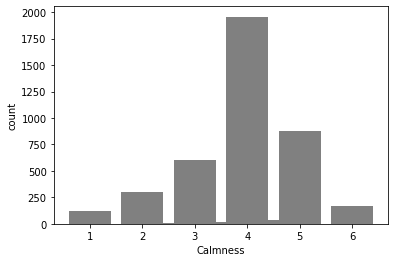

In [48]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(final_day_calm_impute_median), return_counts=True)
plt.bar(u, c, color = "grey")
plt.xlabel('Calmness')
plt.ylabel('count')
fig.savefig("Calmness distr AMDI.pdf", bbox_inches='tight')

In [49]:
result = pyreadr.read_r('day_usage_transposed')
day_usage_transposed = result[None]
del day_usage_transposed["user_id"]

In [50]:
print(day_usage_transposed.isnull().sum().sum())

1482


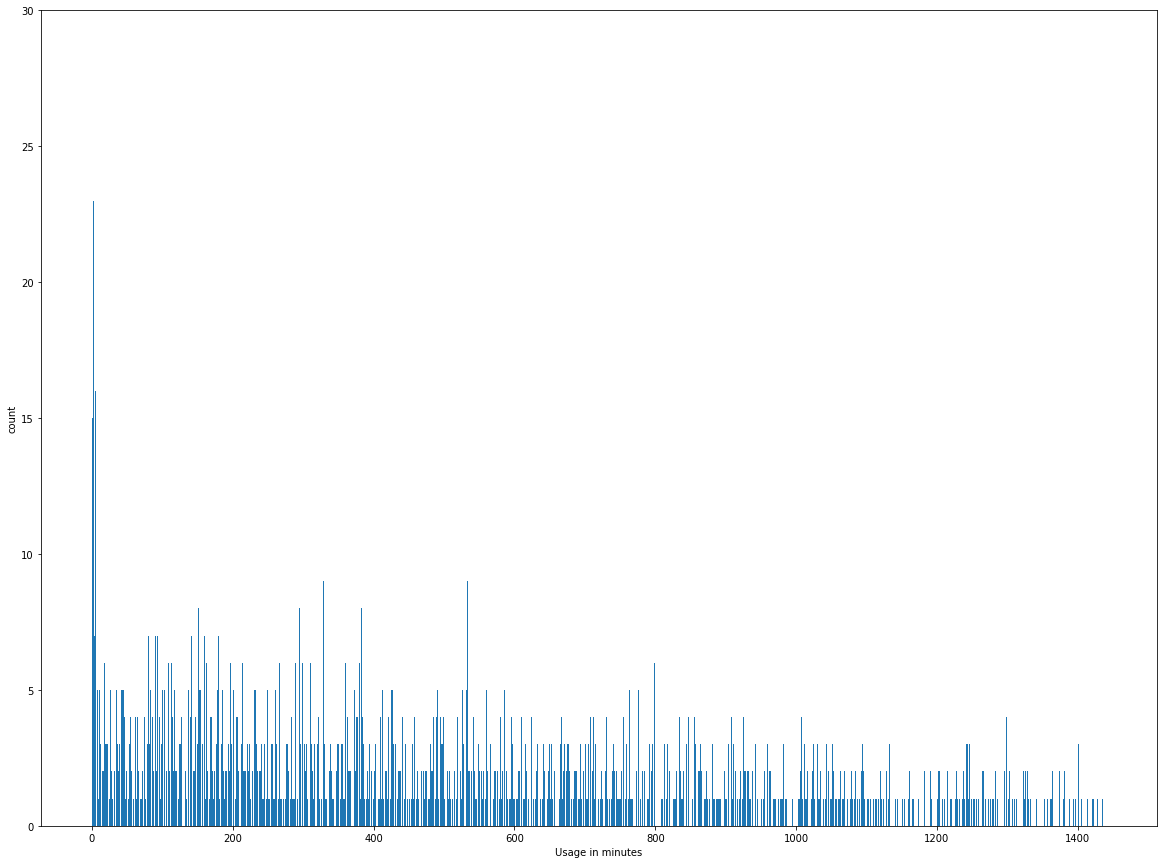

In [195]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(day_usage_transposed)), return_counts=True)
axes = plt.gca()
axes.set_ylim([0,30])
#for number in range(len(u)): 
#    if u[number] > 1440:
#        u[number] = 1440
#    else:
#        u[number] = u[number]
plt.bar(u, c)
plt.xlabel('Usage in minutes')
plt.ylabel('count')
fig.savefig("Usage per day BMDI.pdf", bbox_inches='tight')

In [52]:
day_usage_transposed = day_usage_transposed.drop(null_rows.index)

In [53]:
day_usage_transposed_copy = day_usage_transposed.copy()
print(day_usage_transposed.shape)

(120, 34)


In [54]:
day_usage_na = (day_usage_transposed_copy.isnull().sum(axis=1))

In [55]:
vals, counts = numpy.unique(day_usage_na, return_counts=True)
dic_day_usage_na = dict(zip(vals, counts))
dic_day_usage_na
#shape is 34!
##check how many users (22) have less than 5 na values

{0: 9,
 1: 6,
 2: 2,
 4: 3,
 5: 2,
 6: 11,
 7: 15,
 8: 19,
 9: 5,
 10: 9,
 11: 2,
 12: 1,
 13: 3,
 14: 5,
 15: 2,
 16: 2,
 17: 1,
 19: 1,
 20: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 2,
 28: 3,
 29: 4,
 30: 2,
 31: 4,
 32: 3}

In [56]:
day_usage_few_na = day_usage_transposed_copy[day_usage_transposed_copy.isnull().sum(axis=1) <= 5]
day_usage_few_na_copy = day_usage_few_na.copy()

In [57]:
random.seed(113)

day_usage_few_na_matrix = numpy.zeros((130, day_usage_few_na_copy.shape[1]))

for index, row in day_usage_few_na_copy.iterrows():
    row = numpy.array(row)
    random_index = randrange(len(row))
    z = row[random_index]
    while numpy.isnan(z) or z == 0:
        random_index = randrange(len(row))
        z = row[random_index]
    else:
        day_usage_few_na_copy.loc[index][random_index] = numpy.nan
        day_usage_few_na_matrix[index][random_index] = z   

In [58]:
day_usage_impute_mean = day_usage_few_na_copy.apply(lambda x: x.fillna(x.mean()),axis=1)
day_usage_impute_median = day_usage_few_na_copy.apply(lambda x: x.fillna(x.median()),axis=1)
day_usage_impute_linear = day_usage_few_na_copy.interpolate(method = "linear", limit_direction = "both")
day_usage_impute_quadratic = day_usage_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
day_usage_impute_cubic = day_usage_few_na_copy.interpolate(method = "cubic", limit_direction = "both")

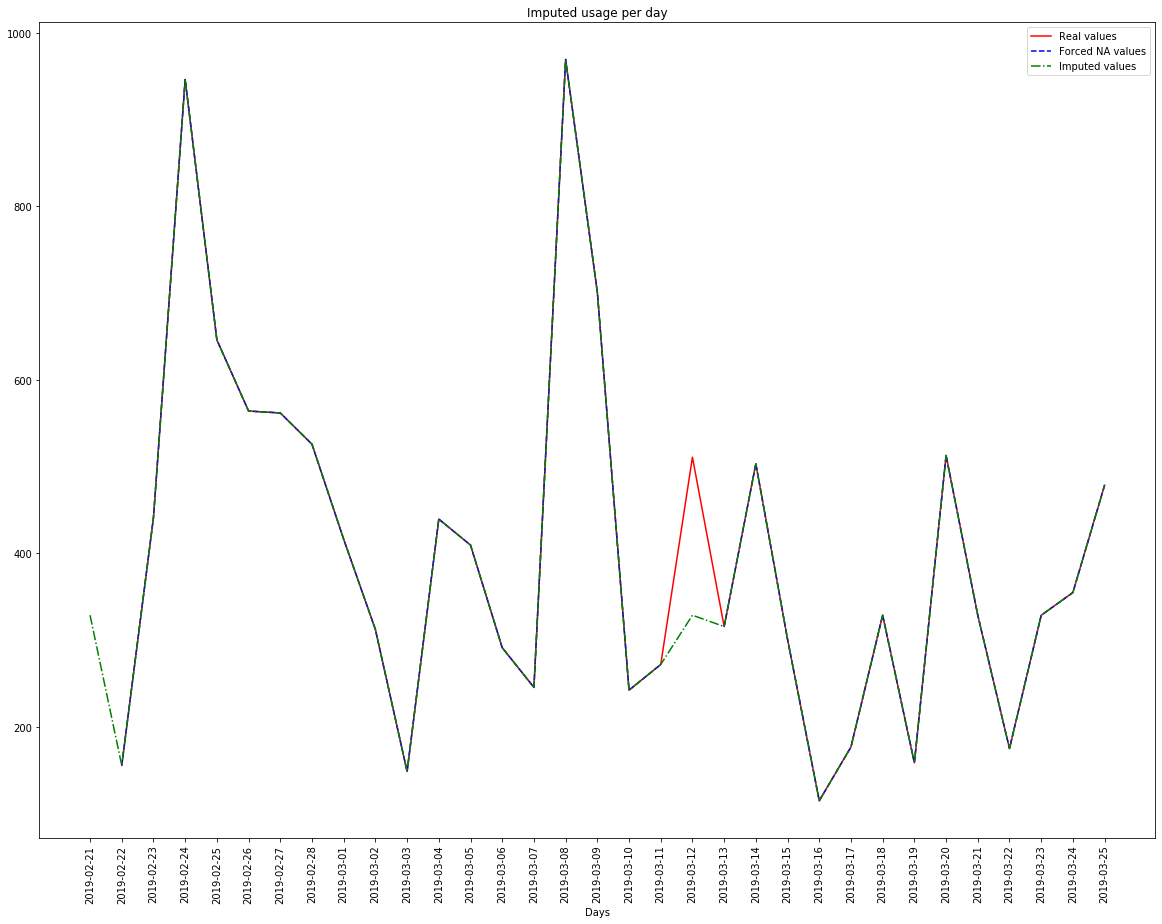

In [199]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_usage_few_na.iloc[0])
plt.plot(day_usage_few_na.iloc[21, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_usage_few_na_copy.iloc[21, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_usage_impute_median.iloc[21, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Days"),
       title='Imputed usage per day');
fig.savefig("Usage 21 day.pdf", bbox_inches='tight')

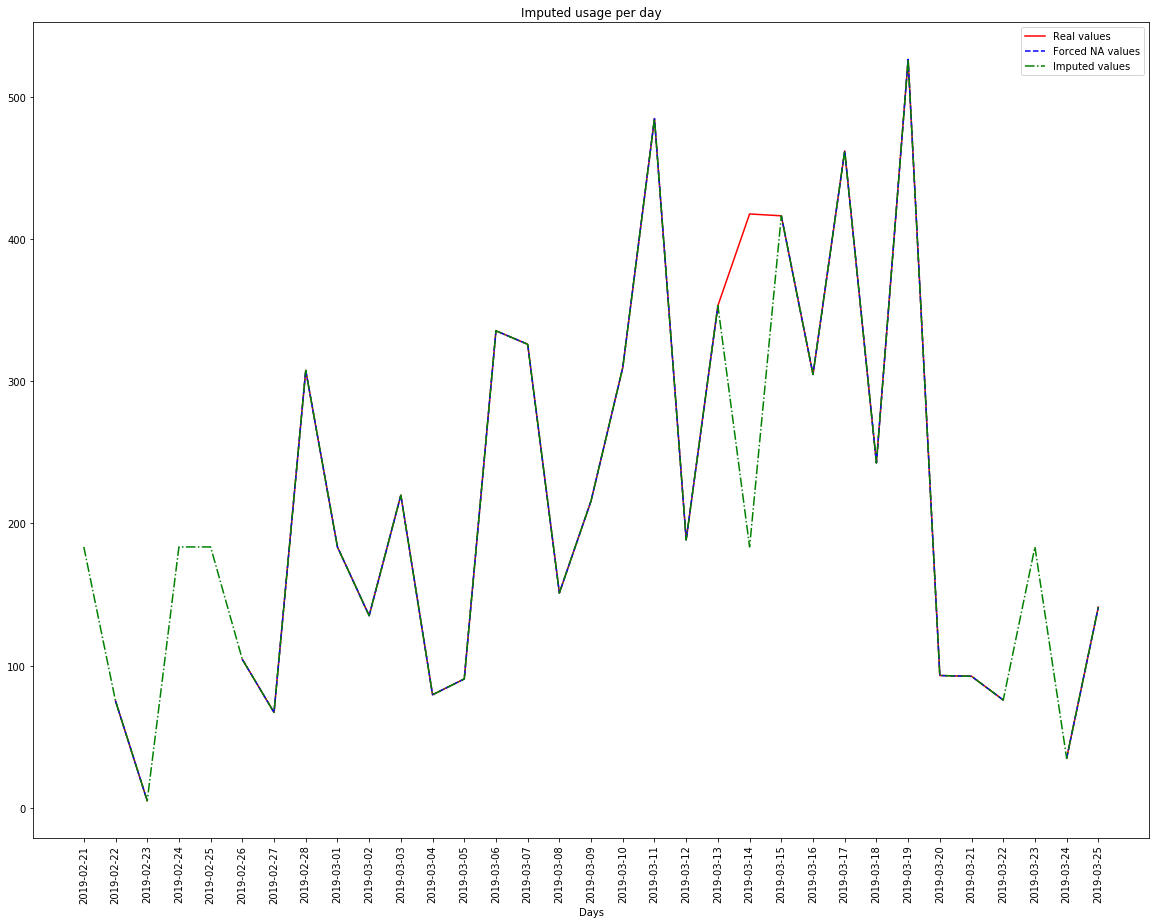

In [200]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_usage_few_na.iloc[0])
plt.plot(day_usage_few_na.iloc[16, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_usage_few_na_copy.iloc[16, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_usage_impute_median.iloc[16, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Days"),
       title='Imputed usage per day');
fig.savefig("Usage 18 day.pdf", bbox_inches='tight')

In [61]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_usage_few_na_matrix)):
    if numpy.all(day_usage_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_usage_few_na_matrix[array])[0]
        y = day_usage_few_na_matrix[array][y_index]
        w = day_usage_impute_mean.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[3252.78609305] [2189.90565076]
5442.691743810706


In [62]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_usage_few_na_matrix)):
    if numpy.all(day_usage_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_usage_few_na_matrix[array])[0]
        y = day_usage_few_na_matrix[array][y_index]
        w = day_usage_impute_median.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[3199.10881684] [1833.22940831]
5032.338225144147


In [63]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_usage_few_na_matrix)):
    if numpy.all(day_usage_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_usage_few_na_matrix[array])[0]
        y = day_usage_few_na_matrix[array][y_index]
        w = day_usage_impute_linear.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[6580.3255499] [5007.65616608]
11587.98171597322


In [64]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_usage_few_na_matrix)):
    if numpy.all(day_usage_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_usage_few_na_matrix[array])[0]
        y = day_usage_few_na_matrix[array][y_index]
        w = day_usage_impute_quadratic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[7801.17899997] [5356.52817924]
13157.707179207311


C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [65]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_usage_few_na_matrix)):
    if numpy.all(day_usage_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_usage_few_na_matrix[array])[0]
        y = day_usage_few_na_matrix[array][y_index]
        w = day_usage_impute_cubic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


[9203.93008294] [5414.40058378]
14618.330666713346


In [202]:
final_day_usage_impute_median = day_usage_transposed.apply(lambda x: x.fillna(x.median()),axis=1)

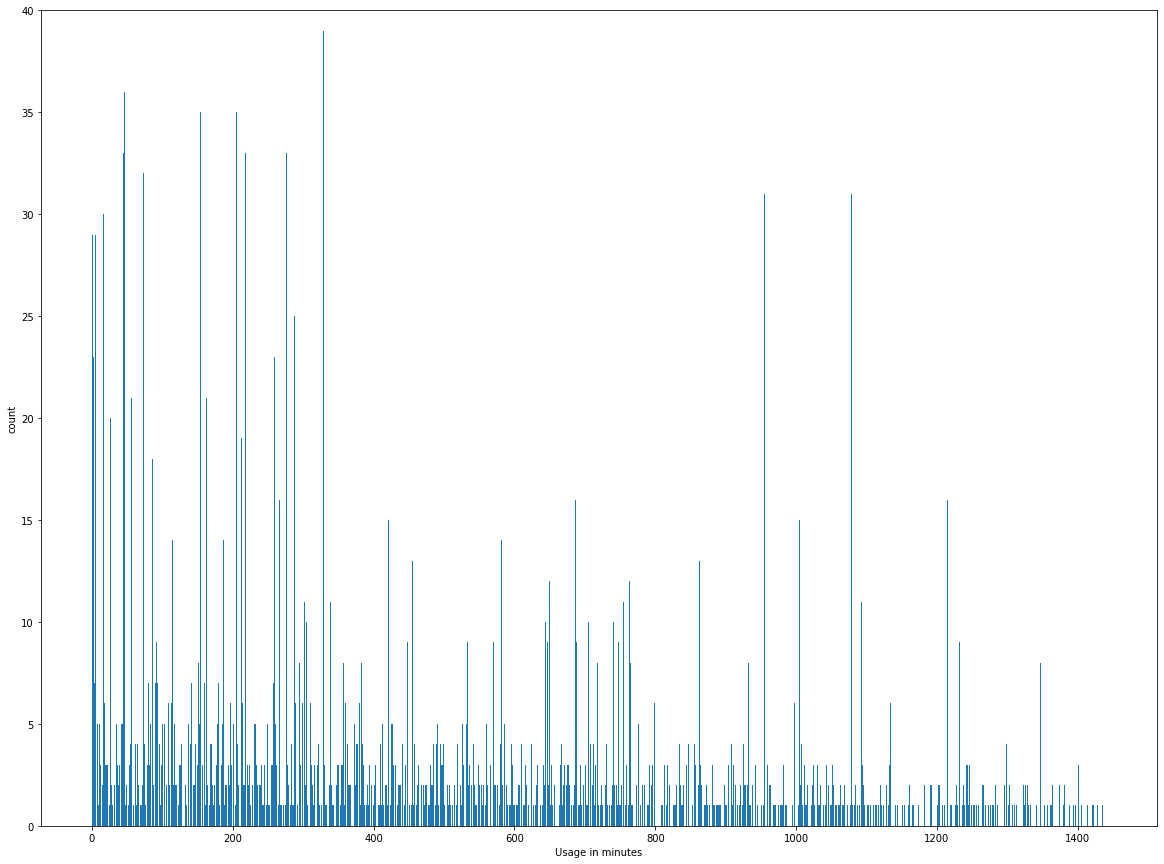

In [203]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(final_day_usage_impute_median)), return_counts=True)

#for number in range(len(u)): 
#    if u[number] > 1440:
#        u[number] = 1440
#    else:
#        u[number] = u[number]
axes = plt.gca()
axes.set_ylim([0,40])

plt.bar(u, c)
plt.xlabel('Usage in minutes')
plt.ylabel('count')
fig.savefig("Usage per day AMDI.pdf", bbox_inches='tight')

In [68]:
result = pyreadr.read_r('day_times_transposed')
day_times_transposed = result[None]
del day_times_transposed["user_id"]

In [69]:
print(day_times_transposed.isnull().sum().sum())

1482


In [70]:
day_times_transposed = day_times_transposed.drop(null_rows.index)

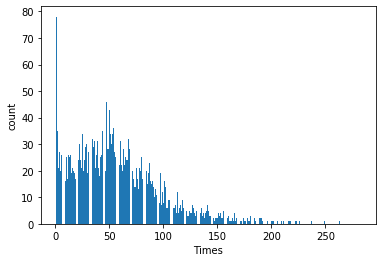

In [71]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(day_times_transposed)), return_counts=True)
plt.bar(u, c)
plt.xlabel('Times')
plt.ylabel('count')
fig.savefig("Times per day BMDI.pdf", bbox_inches='tight')

In [72]:
day_times_transposed_copy = day_times_transposed.copy()
print(day_times_transposed.shape)

(120, 34)


In [73]:
day_times_na = (day_times_transposed_copy.isnull().sum(axis=1))

In [74]:
vals, counts = numpy.unique(day_times_na, return_counts=True)
dic_day_times_na = dict(zip(vals, counts))
dic_day_times_na
#shape is 34!
##check how many users (22) have less than 5 na values

{0: 9,
 1: 6,
 2: 2,
 4: 3,
 5: 2,
 6: 11,
 7: 15,
 8: 19,
 9: 5,
 10: 9,
 11: 2,
 12: 1,
 13: 3,
 14: 5,
 15: 2,
 16: 2,
 17: 1,
 19: 1,
 20: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 2,
 28: 3,
 29: 4,
 30: 2,
 31: 4,
 32: 3}

In [75]:
day_times_few_na = day_times_transposed_copy[day_times_transposed_copy.isnull().sum(axis=1) <= 5]
day_times_few_na_copy = day_times_few_na.copy()

In [76]:
random.seed(113)
day_times_few_na_matrix = numpy.zeros((130, day_times_few_na_copy.shape[1]))

for index, row in day_times_few_na_copy.iterrows():
    row = numpy.array(row)
    random_index = randrange(len(row))
    z = row[random_index]
    while numpy.isnan(z) or z == 0:
        random_index = randrange(len(row))
        z = row[random_index]
    else:
        day_times_few_na_copy.loc[index][random_index] = numpy.nan
        day_times_few_na_matrix[index][random_index] = z   

In [77]:
day_times_impute_mean = day_times_few_na_copy.apply(lambda x: x.fillna(x.mean()),axis=1)
day_times_impute_median = day_times_few_na_copy.apply(lambda x: x.fillna(x.median()),axis=1)
day_times_impute_linear = day_times_few_na_copy.interpolate(method = "linear", limit_direction = "both")
day_times_impute_quadratic = day_times_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
day_times_impute_cubic = day_times_few_na_copy.interpolate(method = "cubic", limit_direction = "both")

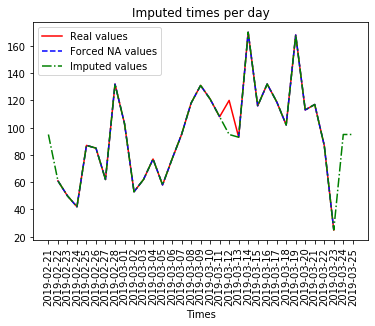

In [78]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_times_few_na.iloc[0])
plt.plot(day_times_few_na.iloc[14, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_times_few_na_copy.iloc[14, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_times_impute_median.iloc[14, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Times"),
       title='Imputed times per day');
fig.savefig("Times day 14.pdf", bbox_inches='tight')

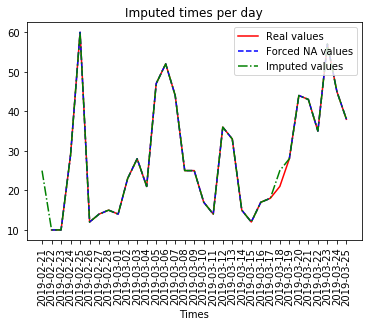

In [79]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(day_times_few_na.iloc[0])
plt.plot(day_times_few_na.iloc[17, 0:33], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(day_times_few_na_copy.iloc[17, 0:33], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(day_times_impute_median.iloc[17, 0:33], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("Times"),
       title='Imputed times per day');
fig.savefig("Times day 17.pdf", bbox_inches='tight')

In [80]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_times_few_na_matrix)):
    if numpy.all(day_times_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_times_few_na_matrix[array])[0]
        y = day_times_few_na_matrix[array][y_index]
        w = day_times_impute_mean.loc[array][y_index][0]
        w = int(w)
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[134.] [198.]
332.0


In [81]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_times_few_na_matrix)):
    if numpy.all(day_times_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_times_few_na_matrix[array])[0]
        y = day_times_few_na_matrix[array][y_index]
        w = day_times_impute_median.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[134.] [168.]
302.0


In [82]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_times_few_na_matrix)):
    if numpy.all(day_times_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_times_few_na_matrix[array])[0]
        y = day_times_few_na_matrix[array][y_index]
        w = day_times_impute_linear.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[369.] [652.]
1021.0


In [83]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_times_few_na_matrix)):
    if numpy.all(day_times_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_times_few_na_matrix[array])[0]
        y = day_times_few_na_matrix[array][y_index]
        w = day_times_impute_quadratic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[485.39792016] [793.377703]
1278.7756231613635


C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [84]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(day_times_few_na_matrix)):
    if numpy.all(day_times_few_na_matrix[array] == 0):
        continue
    else:
        y_index = numpy.nonzero(day_times_few_na_matrix[array])[0]
        y = day_times_few_na_matrix[array][y_index]
        w = day_times_impute_cubic.loc[array][y_index][0]
        diff = w - y
        if diff > 0:
            plus_diff += diff
        elif diff < 0:            
            min_diff -= diff 
print(min_diff, plus_diff) 
print(sum(min_diff + plus_diff))

[564.04639365] [808.49396642]
1372.5403600744162


C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\suzan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [85]:
final_day_times_impute_median = day_times_transposed.apply(lambda x: x.fillna(x.median()),axis=1)

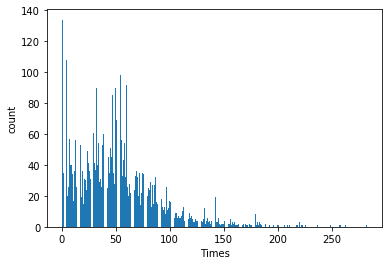

In [86]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(final_day_times_impute_median)), return_counts=True)
plt.bar(u, c)
plt.xlabel('Times')
plt.ylabel('count')
fig.savefig("Times per day AMDI.pdf", bbox_inches='tight')

In [87]:
result = pyreadr.read_r('part_usage_transposed')
part_usage_transposed = result[None]
del part_usage_transposed["user_id"]

In [88]:
print(part_usage_transposed.isnull().sum().sum())

7126


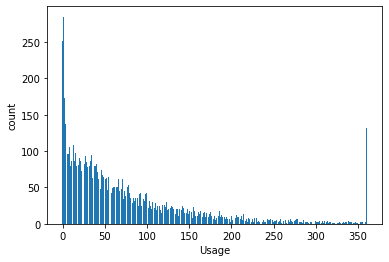

In [89]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(part_usage_transposed)), return_counts=True)

#for number in range(len(u)): 
#    if u[number] > 360:
#        u[number] = 360
#    else:
#        u[number] = u[number]
        
plt.bar(u, c)
plt.xlabel('Usage')
plt.ylabel('count')
fig.savefig("Usage per part of the day BMDI.pdf", bbox_inches='tight')

In [90]:
part_usage_transposed = part_usage_transposed.drop(null_rows.index)

In [91]:
part_usage_transposed_copy = part_usage_transposed.copy()
print(part_usage_transposed.shape)
##shape is 133 columns

(120, 133)


In [92]:
part_usage_na = (part_usage_transposed_copy.isnull().sum(axis=1))

In [93]:
vals, counts = numpy.unique(part_usage_na, return_counts=True)
dic_part_usage_na = dict(zip(vals, counts))
dic_part_usage_na
#shape is 132!
##check how many users (15) have less than 18 na values

{4: 1,
 5: 1,
 6: 3,
 7: 1,
 8: 1,
 10: 1,
 12: 1,
 13: 1,
 14: 1,
 17: 1,
 18: 3,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 2,
 28: 2,
 29: 3,
 30: 1,
 31: 2,
 32: 1,
 33: 5,
 34: 3,
 35: 5,
 36: 4,
 37: 3,
 38: 1,
 39: 2,
 40: 2,
 41: 5,
 42: 2,
 43: 1,
 44: 4,
 45: 2,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 51: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 61: 1,
 62: 1,
 65: 1,
 66: 2,
 67: 1,
 68: 1,
 69: 2,
 71: 1,
 73: 2,
 76: 1,
 78: 1,
 81: 1,
 83: 1,
 93: 1,
 98: 2,
 99: 1,
 105: 1,
 106: 1,
 109: 1,
 111: 1,
 113: 1,
 114: 2,
 116: 2,
 117: 1,
 120: 1,
 121: 1,
 122: 1,
 124: 2,
 126: 2,
 127: 1,
 128: 1,
 129: 1,
 130: 1}

In [94]:
part_usage_few_na = part_usage_transposed_copy[part_usage_transposed_copy.isnull().sum(axis=1) <= 18]
part_usage_few_na_copy = part_usage_few_na.copy()

In [95]:
random.seed(113)
part_usage_few_na_matrix = numpy.zeros((130, part_usage_few_na_copy.shape[1]))

for index, row in part_usage_few_na_copy.iterrows():
    row = numpy.array(row)
    for i in range(2):
        random_index = randrange(len(row))
        z = row[random_index]
        while numpy.isnan(z) or z == 0:
            random_index = randrange(len(row))
            z = row[random_index]
        else:
            part_usage_few_na_copy.loc[index][random_index] = numpy.nan
            part_usage_few_na_matrix[index,random_index] = z  

In [96]:
part_usage_impute_mean = part_usage_few_na_copy.apply(lambda x: x.fillna(x.mean()),axis=1)
part_usage_impute_median = part_usage_few_na_copy.apply(lambda x: x.fillna(x.median()),axis=1)
part_usage_impute_linear = part_usage_few_na_copy.interpolate(method = "linear", limit_direction = "both")
part_usage_impute_quadratic = part_usage_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
part_usage_impute_cubic = part_usage_few_na_copy.interpolate(method = "cubic", limit_direction = "both")

In [97]:
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = "20, 15"

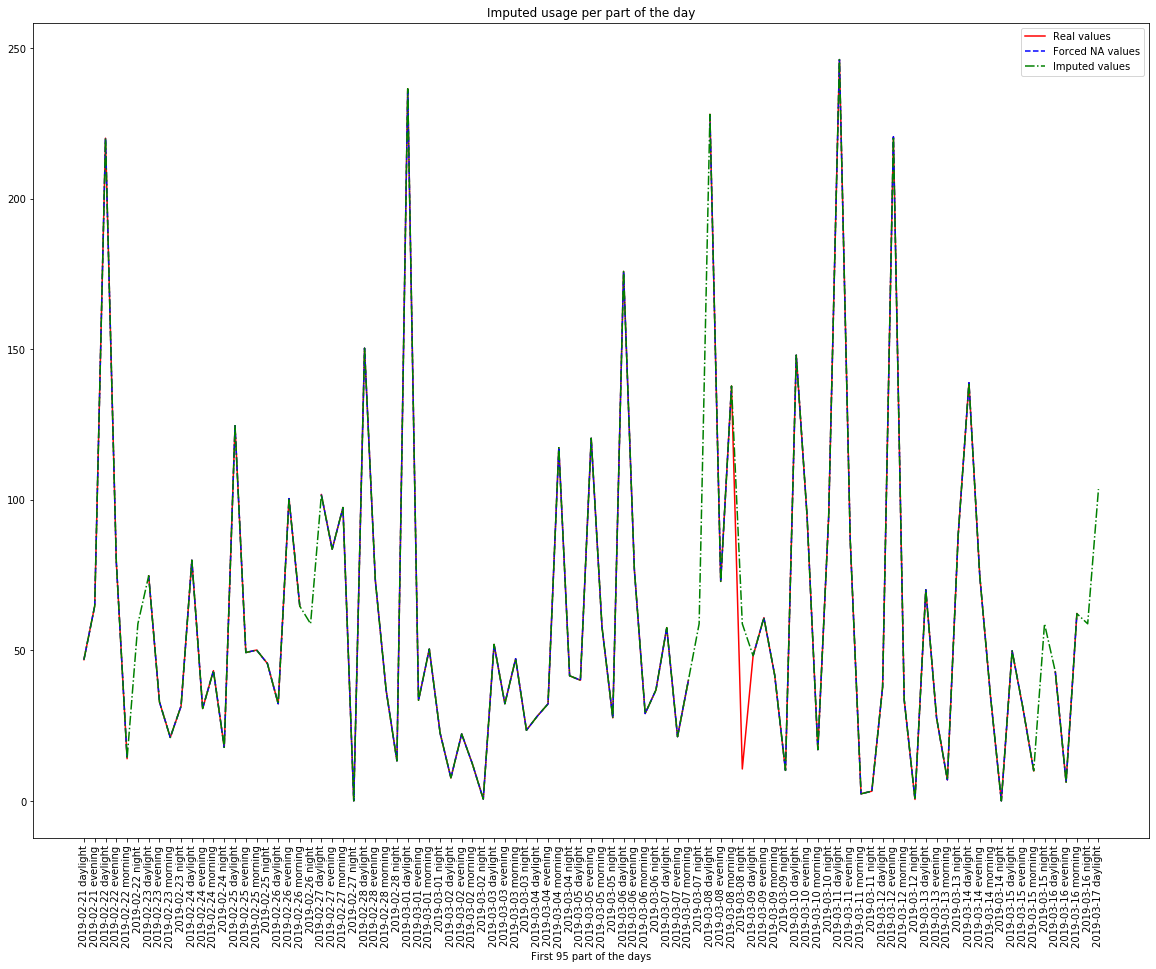

In [98]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(part_usage_few_na.iloc[0])
plt.plot(part_usage_few_na.iloc[2, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(part_usage_few_na_copy.iloc[2, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(part_usage_impute_mean.iloc[2, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 part of the days"),
       title='Imputed usage per part of the day');
fig.savefig("Usage mean 1.pdf", bbox_inches='tight')

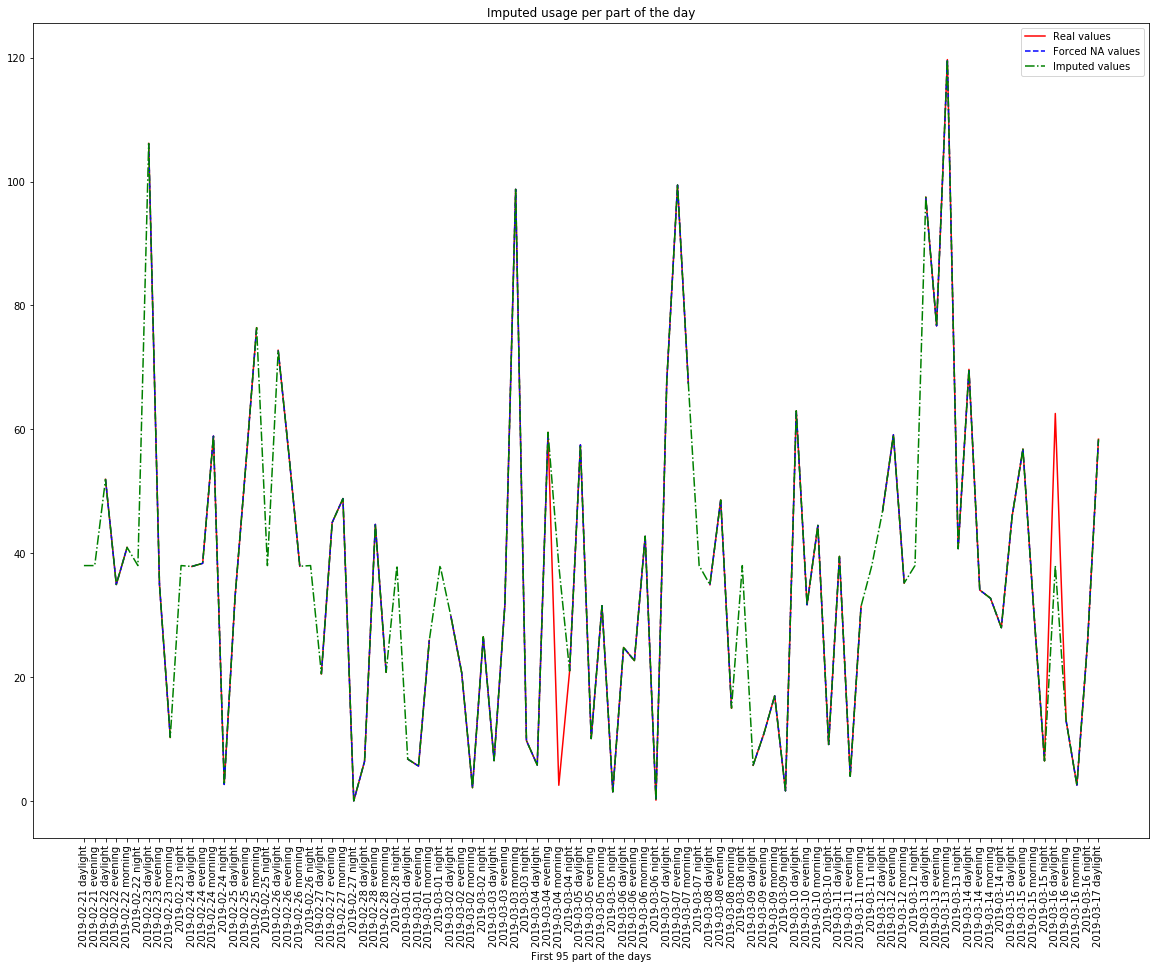

In [99]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(part_usage_few_na.iloc[0])
plt.plot(part_usage_few_na.iloc[9, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(part_usage_few_na_copy.iloc[9, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(part_usage_impute_mean.iloc[9, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 part of the days"),
       title='Imputed usage per part of the day');
fig.savefig("Usage mean 9.pdf", bbox_inches='tight')

In [100]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_usage_few_na_matrix)):
    if numpy.all(part_usage_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(part_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_usage_few_na_matrix[array,value]
                ##print(y)
                w = int(part_usage_impute_mean.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

1168.65713326931 391.1905166387558
1559.8476499080657


In [101]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_usage_few_na_matrix)):
    if numpy.all(part_usage_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(part_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_usage_few_na_matrix[array,value]
                ##print(y)
                w = int(part_usage_impute_median.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

1389.2284332871436 256.76181665658953
1645.990249943733


In [102]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_usage_few_na_matrix)):
    if numpy.all(part_usage_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(part_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_usage_few_na_matrix[array,value]
                ##print(y)
                w = int(part_usage_impute_linear.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

1299.2928166389465 517.8262000083923
1817.1190166473389


In [103]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_usage_few_na_matrix)):
    if numpy.all(part_usage_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(part_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_usage_few_na_matrix[array,value]
                ##print(y)
                w = part_usage_impute_quadratic.loc[array][value]
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

1357.5248825539277 1175.8323377436616
2533.3572202975893


In [104]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_usage_few_na_matrix)):
    if numpy.all(part_usage_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(part_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_usage_few_na_matrix[array,value]
                ##print(y)
                w = part_usage_impute_cubic.loc[array][value]
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

2002.2654869165144 1358.462664377815
3360.728151294329


In [105]:
final_part_usage_impute_mean = part_usage_transposed.apply(lambda x: x.fillna(x.mean()),axis=1)

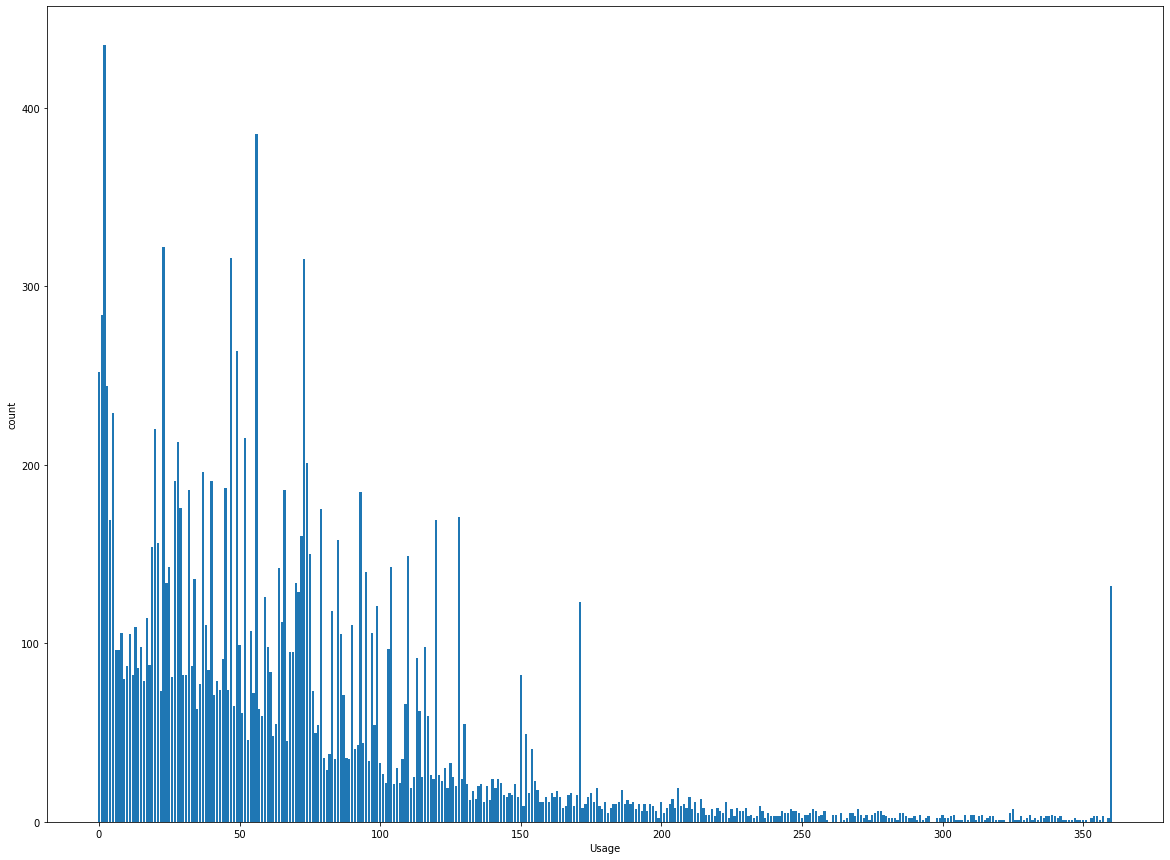

In [106]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(final_part_usage_impute_mean)), return_counts=True)
#for number in range(len(u)): 
#    if u[number] > 360:
#        u[number] = 360
#    else:
#        u[number] = u[number]
plt.bar(u, c)
plt.xlabel('Usage')
plt.ylabel('count')
fig.savefig("Usage per part of the day AMDI.pdf", bbox_inches='tight')

In [107]:
result = pyreadr.read_r('part_times_transposed')
part_times_transposed = result[None]
del part_times_transposed["user_id"]

In [108]:
print(part_times_transposed.isnull().sum().sum())

7126


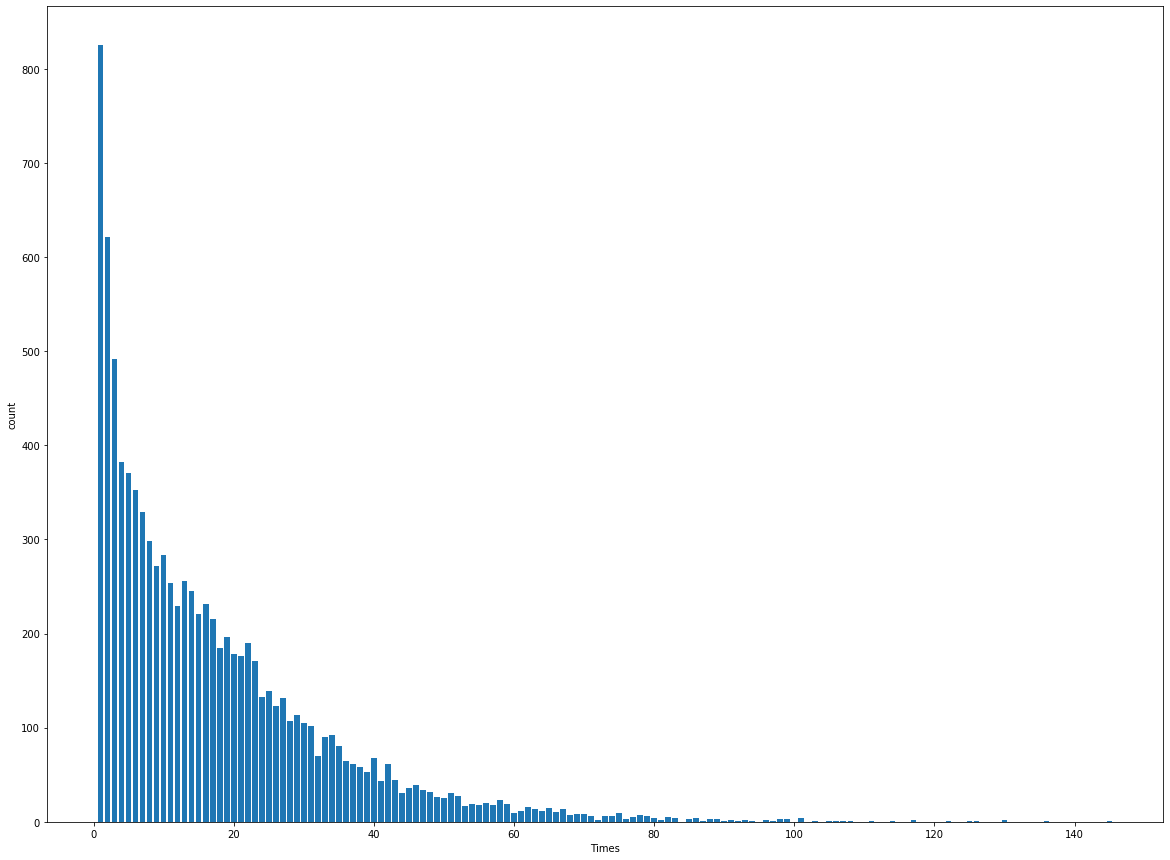

In [109]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(part_times_transposed)), return_counts=True)
plt.bar(u, c)
plt.xlabel('Times')
plt.ylabel('count')
fig.savefig("Times per part of the day BMDI.pdf", bbox_inches='tight')

In [110]:
part_times_transposed = part_times_transposed.drop(null_rows.index)

In [111]:
part_times_transposed_copy = part_times_transposed.copy()
print(part_times_transposed_copy.shape)
##shape is 132 columns

(120, 133)


In [112]:
part_times_na = (part_times_transposed_copy.isnull().sum(axis=1))

In [113]:
vals, counts = numpy.unique(part_times_na, return_counts=True)
dic_part_times_na = dict(zip(vals, counts))
dic_part_times_na
#shape is 133!
##check how many users (15) have less than 18 na values

{4: 1,
 5: 1,
 6: 3,
 7: 1,
 8: 1,
 10: 1,
 12: 1,
 13: 1,
 14: 1,
 17: 1,
 18: 3,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 2,
 28: 2,
 29: 3,
 30: 1,
 31: 2,
 32: 1,
 33: 5,
 34: 3,
 35: 5,
 36: 4,
 37: 3,
 38: 1,
 39: 2,
 40: 2,
 41: 5,
 42: 2,
 43: 1,
 44: 4,
 45: 2,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 51: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 61: 1,
 62: 1,
 65: 1,
 66: 2,
 67: 1,
 68: 1,
 69: 2,
 71: 1,
 73: 2,
 76: 1,
 78: 1,
 81: 1,
 83: 1,
 93: 1,
 98: 2,
 99: 1,
 105: 1,
 106: 1,
 109: 1,
 111: 1,
 113: 1,
 114: 2,
 116: 2,
 117: 1,
 120: 1,
 121: 1,
 122: 1,
 124: 2,
 126: 2,
 127: 1,
 128: 1,
 129: 1,
 130: 1}

In [114]:
part_times_few_na = part_times_transposed_copy[part_times_transposed_copy.isnull().sum(axis=1) <= 18]
part_times_few_na_copy = part_times_few_na.copy()
print(part_times_few_na.shape)

(15, 133)


In [115]:
random.seed(113)
part_times_few_na_matrix = numpy.zeros((130, part_times_few_na_copy.shape[1]))

for index, row in part_times_few_na_copy.iterrows():
    row = numpy.array(row)
    for i in range(2):
        random_index = randrange(len(row))
        z = row[random_index]
        while numpy.isnan(z) or z == 0:
            random_index = randrange(len(row))
            z = row[random_index]
        else:
            part_times_few_na_copy.loc[index][random_index] = numpy.nan
            part_times_few_na_matrix[index,random_index] = z  

In [116]:
part_times_impute_mean = part_times_few_na_copy.apply(lambda x: x.fillna(x.mean()),axis=1)
part_times_impute_median = part_times_few_na_copy.apply(lambda x: x.fillna(x.median()),axis=1)
part_times_impute_linear = part_times_few_na_copy.interpolate(method = "linear", limit_direction = "both")
part_times_impute_quadratic = part_times_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
part_times_impute_cubic = part_times_few_na_copy.interpolate(method = "cubic", limit_direction = "both")

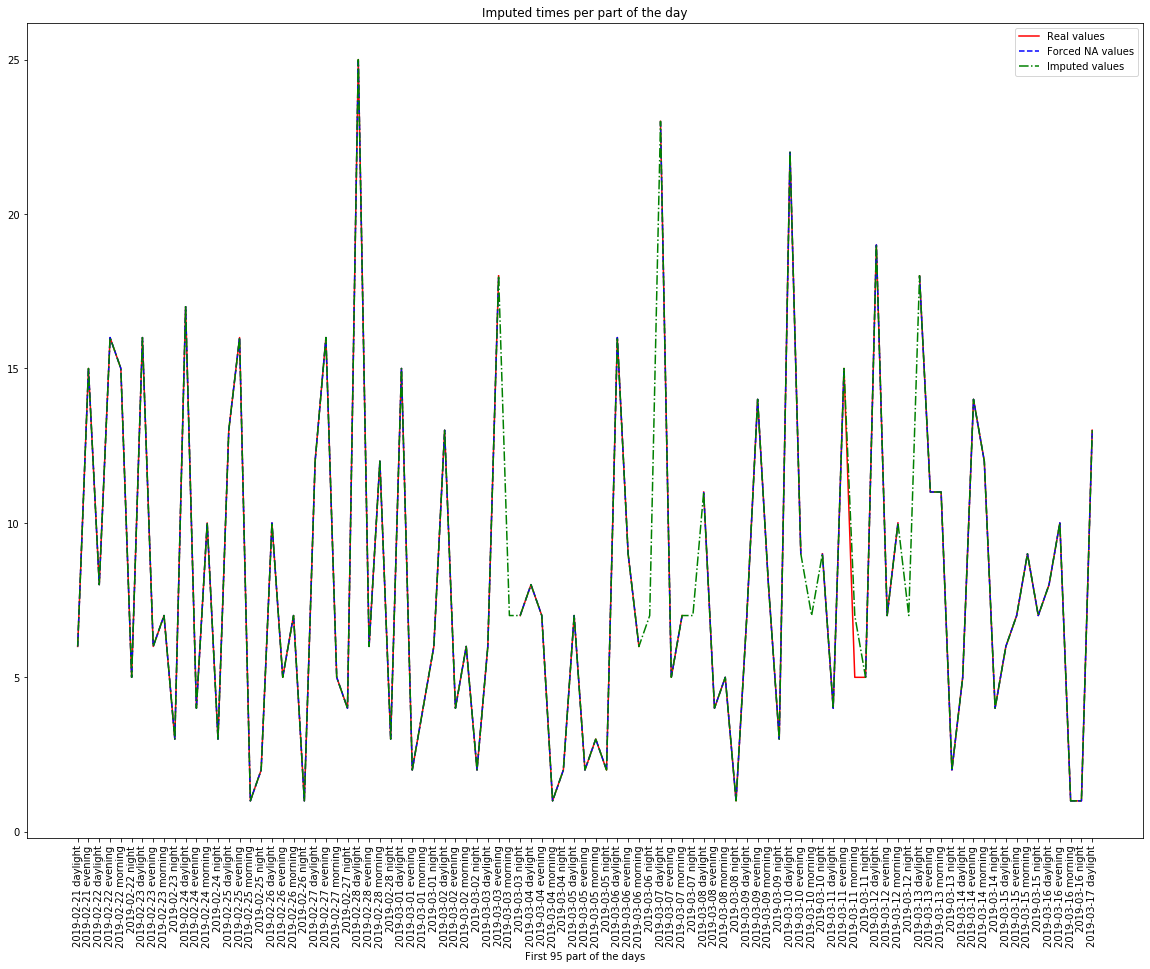

In [117]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(part_times_few_na.iloc[0])
plt.plot(part_times_few_na.iloc[5, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(part_times_few_na_copy.iloc[5, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(part_times_impute_median.iloc[5, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 part of the days"),
       title='Imputed times per part of the day');
fig.savefig("Timer part day 5.pdf", bbox_inches='tight')

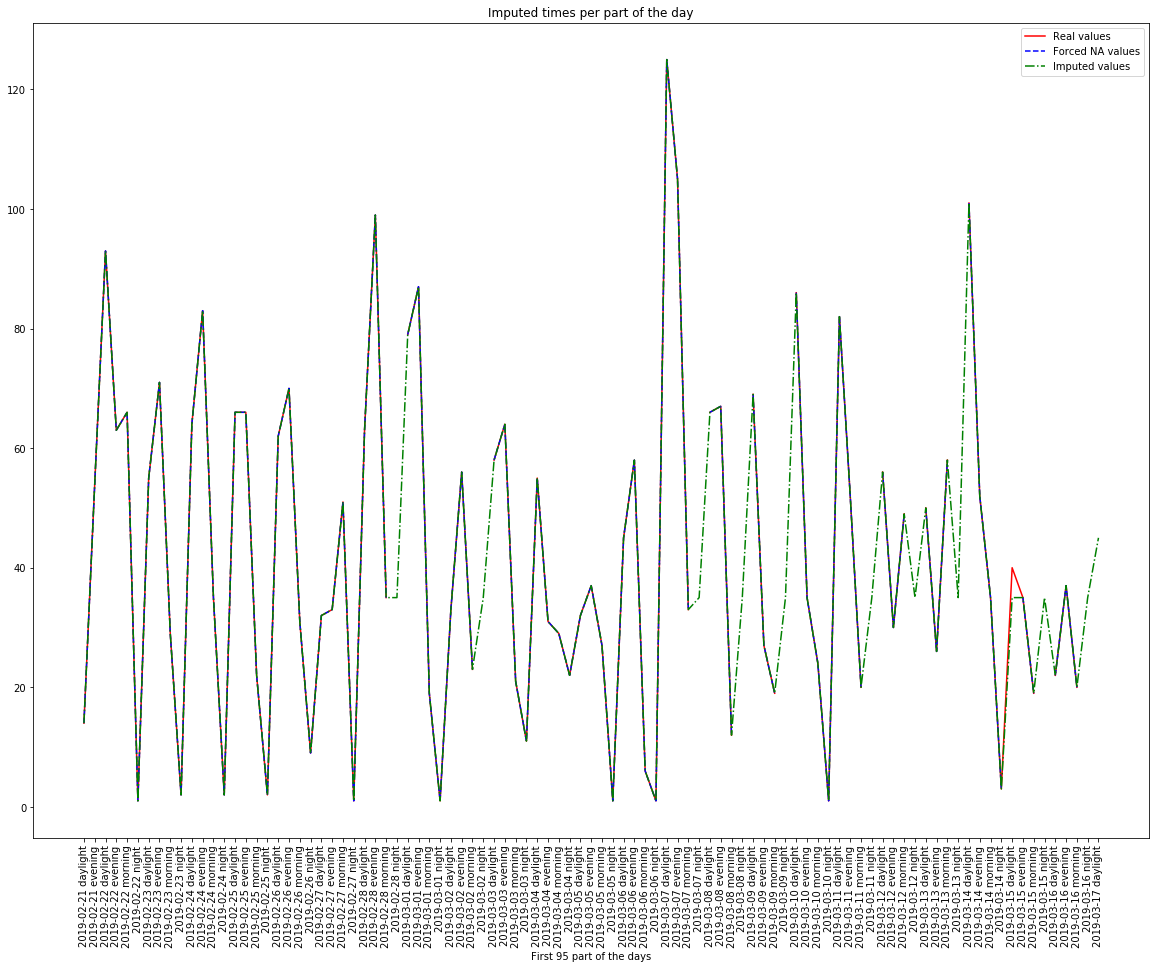

In [118]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(part_times_few_na.iloc[0])
plt.plot(part_times_few_na.iloc[6, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(part_times_few_na_copy.iloc[6, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(part_times_impute_median.iloc[6, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 part of the days"),
       title='Imputed times per part of the day');
fig.savefig("Timer part day 6.pdf", bbox_inches='tight')

In [119]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_times_few_na_matrix)):
    if numpy.all(part_times_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(part_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_times_few_na_matrix[array,value]
                ##print(y)
                w = int(part_times_impute_mean.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

159.0 145.0
304.0


In [120]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_times_few_na_matrix)):
    if numpy.all(part_times_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(part_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_times_few_na_matrix[array,value]
                ##print(y)
                w = int(part_times_impute_median.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

173.0 118.0
291.0


In [121]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_times_few_na_matrix)):
    if numpy.all(part_times_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(part_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_times_few_na_matrix[array,value]
                ##print(y)
                w = int(part_times_impute_linear.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

230.0 252.0
482.0


In [122]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_times_few_na_matrix)):
    if numpy.all(part_times_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(part_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_times_few_na_matrix[array,value]
                ##print(y)
                w = part_times_impute_quadratic.loc[array][value]
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

557.1453237553892 252.90196144820425
810.0472852035934


In [123]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(part_times_few_na_matrix)):
    if numpy.all(part_times_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(part_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = part_times_few_na_matrix[array,value]
                ##print(y)
                w = part_times_impute_cubic.loc[array][value]
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

522.406949503467 310.8792951831425
833.2862446866095


In [124]:
final_part_times_impute_median = part_times_transposed.apply(lambda x: x.fillna(x.median()),axis=1)

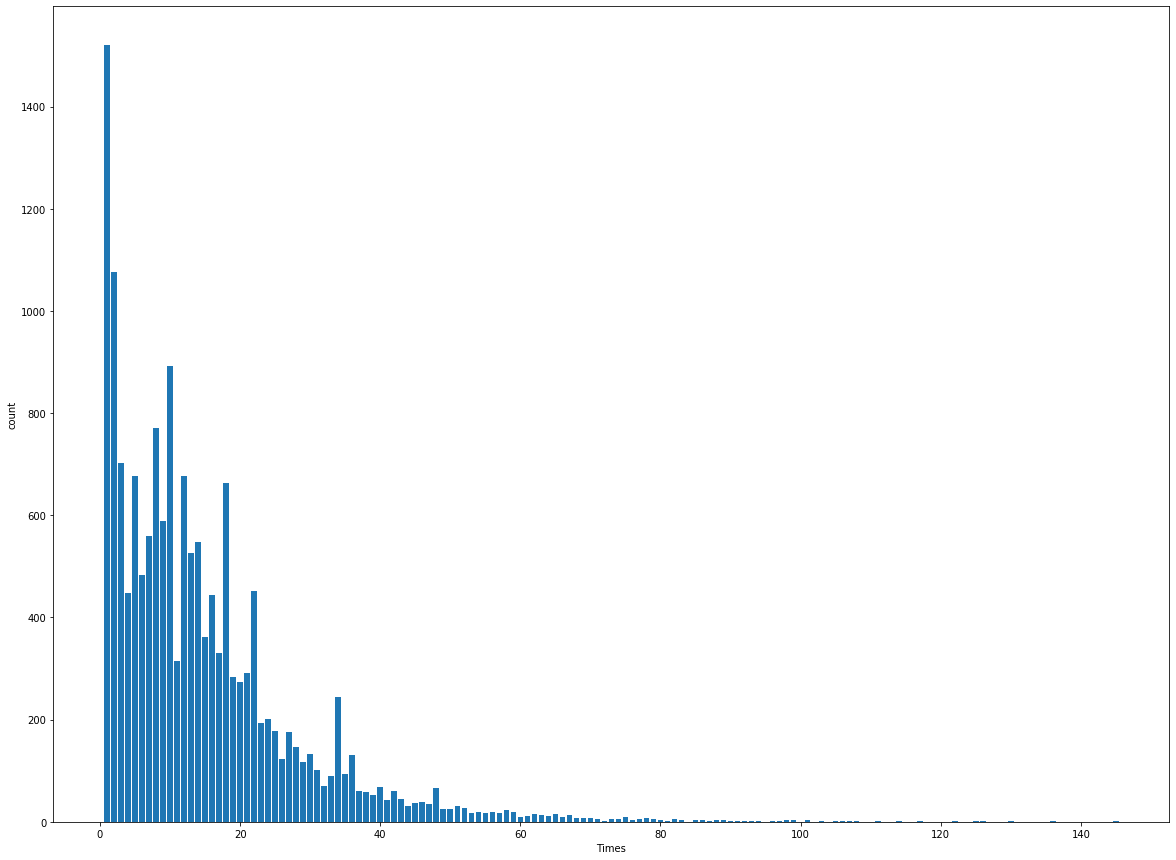

In [125]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(final_part_times_impute_median)), return_counts=True)
plt.bar(u, c)
plt.xlabel('Times')
plt.ylabel('count')
fig.savefig("Times per part of the day AMDI.pdf", bbox_inches='tight')

In [126]:
result = pyreadr.read_r('hour_usage_transposed')
hour_usage_transposed = result[None]
del hour_usage_transposed["user_id"]

In [127]:
print(hour_usage_transposed.isnull().sum().sum())

60982


Text(0, 0.5, 'count')

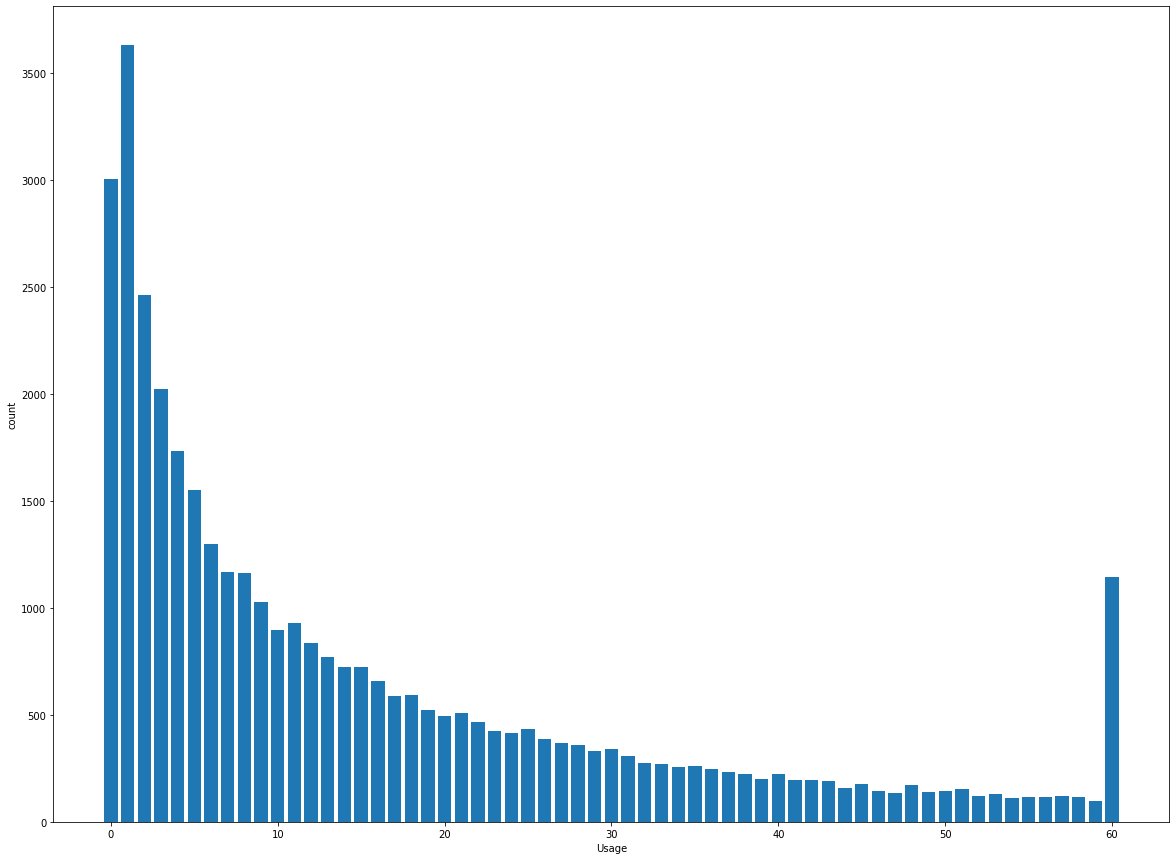

In [128]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(hour_usage_transposed)), return_counts=True)
#for number in range(len(u)): 
#    if u[number] > 60:
#        u[number] = 60
#    else:
#        u[number] = u[number]

plt.bar(u, c)
plt.xlabel('Usage')
plt.ylabel('count')


In [129]:
fig.savefig("Usage per hour BMDI.pdf", bbox_inches='tight')

In [130]:
hour_usage_transposed = hour_usage_transposed.drop(null_rows.index)

In [131]:
hour_usage_transposed_copy = hour_usage_transposed.copy()
print(hour_usage_transposed.shape)

(120, 792)


In [132]:
for col, value in hour_usage_transposed_copy.items(): 
    if col.endswith('23') or col.endswith('00') or col.endswith('01') or col.endswith('02') or col.endswith('03') or col.endswith('04') or col.endswith('05') or col.endswith('06'):
        hour_usage_transposed_copy[col] = hour_usage_transposed_copy[col].fillna(0) 


In [133]:
hour_usage_transposed_mean = hour_usage_transposed.apply(lambda x: x.fillna(x.mean()),axis=1)
first_column_mean = hour_usage_transposed_mean.iloc[:,0]
last_column_mean = hour_usage_transposed_mean.iloc[:,-1]

In [134]:
hour_usage_transposed_copy.iloc[:,0] = first_column_mean
hour_usage_transposed_copy.iloc[:,-1] = last_column_mean

In [135]:
hour_usage_na = (hour_usage_transposed_copy.isnull().sum(axis=1))

In [136]:
vals, counts = numpy.unique(hour_usage_na, return_counts=True)
dic_hour_usage_na = dict(zip(vals, counts))
dic_hour_usage_na
#shape is 792!
##check how many users (19) have less than 148 na values
##40, 189 na's

{40: 1,
 74: 1,
 75: 1,
 79: 1,
 83: 1,
 86: 1,
 99: 1,
 104: 1,
 131: 1,
 132: 1,
 136: 1,
 141: 1,
 143: 1,
 145: 1,
 146: 2,
 147: 2,
 148: 1,
 152: 1,
 153: 1,
 154: 1,
 157: 1,
 161: 1,
 164: 1,
 167: 2,
 168: 2,
 170: 1,
 174: 2,
 177: 1,
 180: 2,
 185: 2,
 188: 1,
 189: 2,
 191: 1,
 192: 1,
 193: 1,
 195: 1,
 196: 1,
 198: 1,
 199: 1,
 201: 1,
 202: 1,
 204: 1,
 206: 2,
 209: 1,
 210: 3,
 212: 1,
 213: 2,
 214: 2,
 224: 1,
 235: 2,
 237: 2,
 244: 1,
 246: 1,
 253: 1,
 254: 2,
 260: 1,
 262: 2,
 272: 1,
 274: 1,
 276: 1,
 277: 1,
 280: 1,
 286: 1,
 291: 1,
 298: 1,
 302: 1,
 322: 2,
 333: 1,
 336: 1,
 342: 1,
 346: 1,
 365: 1,
 378: 1,
 383: 1,
 403: 1,
 407: 1,
 423: 1,
 425: 1,
 434: 1,
 447: 1,
 452: 1,
 458: 1,
 461: 1,
 463: 1,
 465: 1,
 472: 1,
 475: 1,
 476: 1,
 493: 1,
 496: 1,
 503: 1,
 505: 3,
 506: 1,
 507: 1,
 509: 1,
 511: 1,
 514: 2,
 518: 1,
 520: 1}

In [137]:
hour_usage_few_na = hour_usage_transposed_copy[hour_usage_transposed_copy.isnull().sum(axis=1) <= 189]
hour_usage_few_na_copy = hour_usage_few_na.copy()

In [138]:
random.seed(113)
hour_usage_few_na_matrix = numpy.zeros((130, hour_usage_few_na_copy.shape[1]))
print(hour_usage_few_na_copy.shape)

for index, row in hour_usage_few_na_copy.iterrows():
    row = numpy.array(row)
    for i in range(8):
        random_index = randrange(len(row))
        z = row[random_index]
        while numpy.isnan(z) or z == 0:
            random_index = randrange(len(row))
            z = row[random_index]
        else:
            hour_usage_few_na_copy.loc[index][random_index] = numpy.nan
            hour_usage_few_na_matrix[index,random_index] = z   

(40, 792)


In [139]:
hour_usage_impute_mean = hour_usage_few_na_copy.apply(lambda x: x.fillna(x.mean()),axis=1)
hour_usage_impute_median = hour_usage_few_na_copy.apply(lambda x: x.fillna(x.median()),axis=1)
hour_usage_impute_linear = hour_usage_few_na_copy.interpolate(method = "linear", limit_direction = "both")
hour_usage_impute_quadratic = hour_usage_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
hour_usage_impute_cubic = hour_usage_few_na_copy.interpolate(method = "cubic", limit_direction = "both")


In [140]:
max(hour_usage_impute_mean.iloc[18,])

60.0

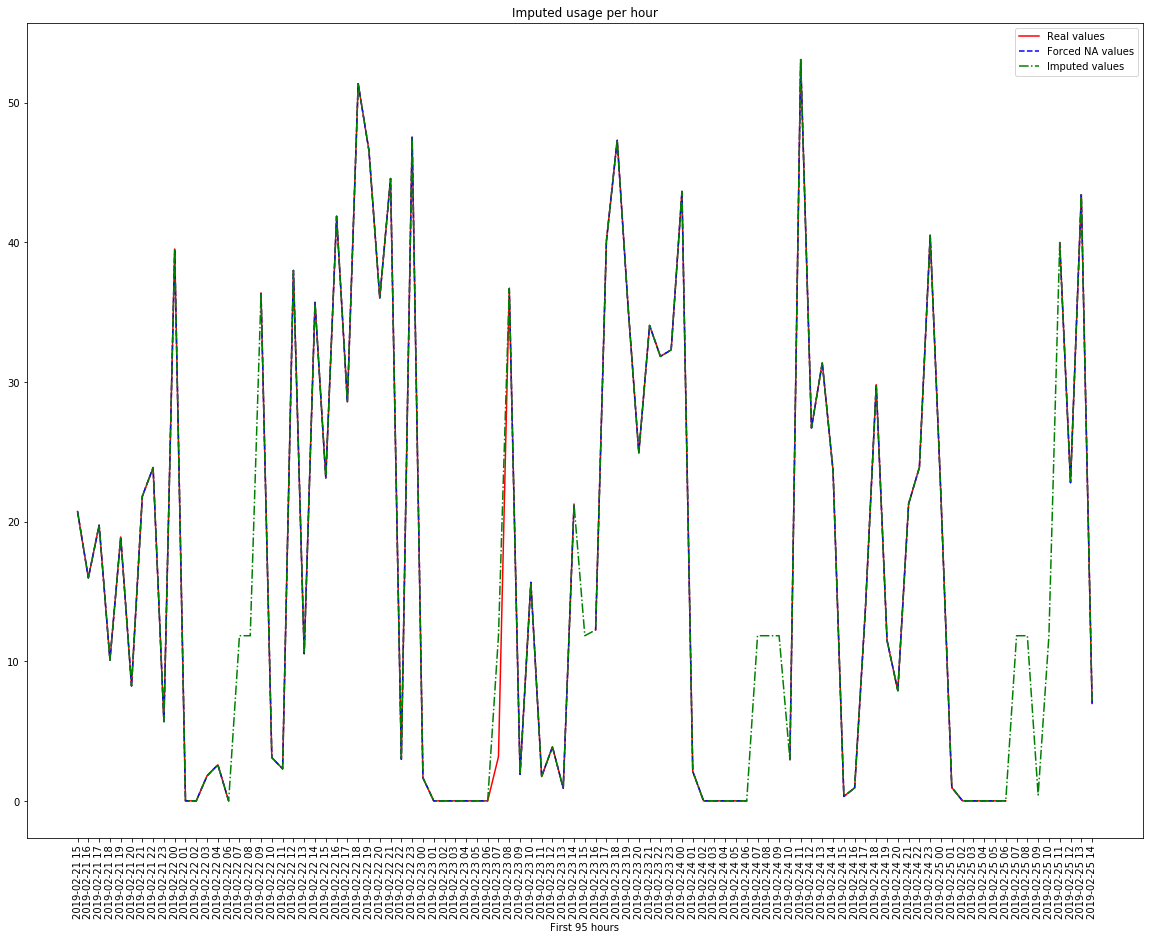

In [141]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(hour_times_few_na.iloc[0])
plt.plot(hour_usage_few_na.iloc[2, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(hour_usage_few_na_copy.iloc[2, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(hour_usage_impute_mean.iloc[2, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 hours"),
       title='Imputed usage per hour');
fig.savefig("usage hour 2.pdf", bbox_inches='tight')

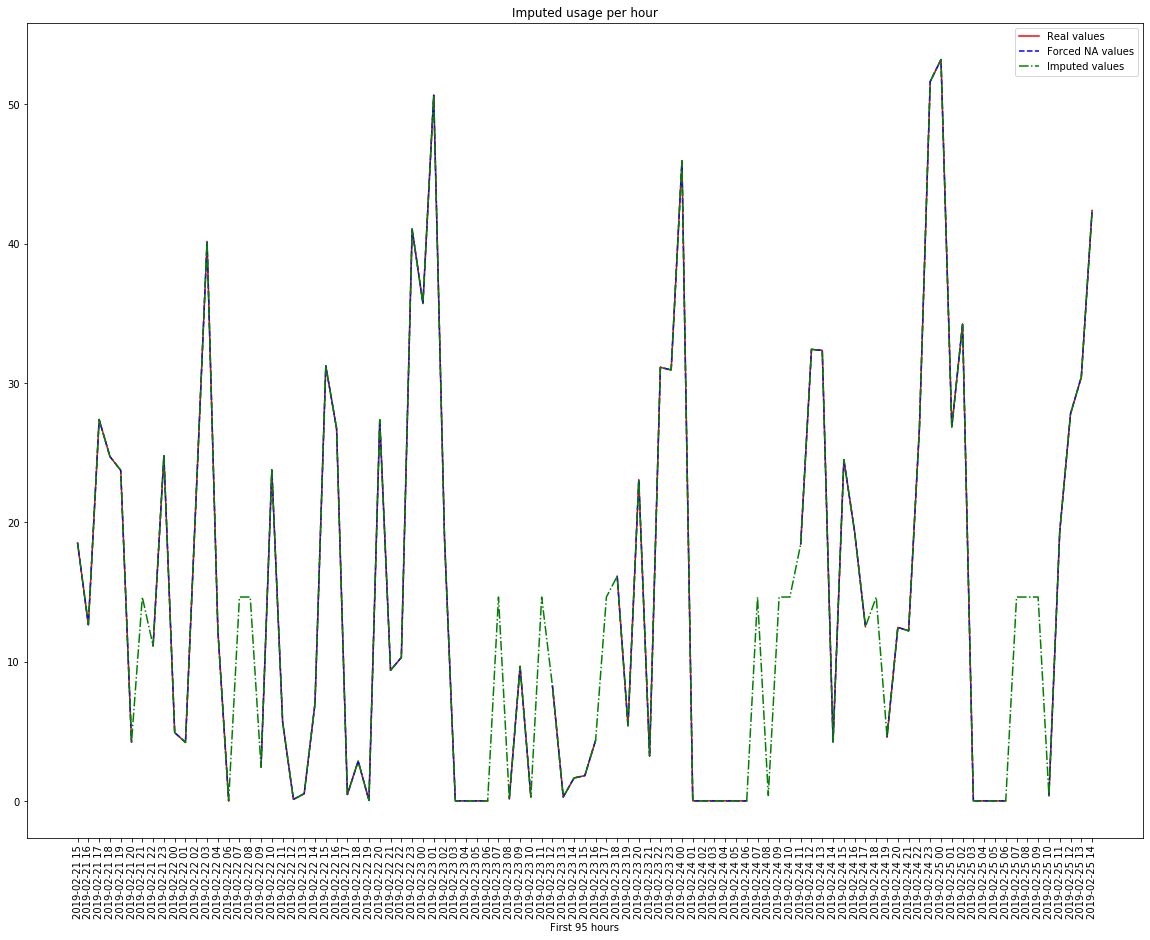

In [142]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(hour_times_few_na.iloc[0])
plt.plot(hour_usage_few_na.iloc[13, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(hour_usage_few_na_copy.iloc[13, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(hour_usage_impute_mean.iloc[13, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 hours"),
       title='Imputed usage per hour');
fig.savefig("usage hour 12.pdf", bbox_inches='tight')

In [143]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_usage_few_na_matrix)):
    if numpy.all(hour_usage_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(hour_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_usage_few_na_matrix[array,value]
                ##print(y)
                w = int(hour_usage_impute_mean.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff
print(min_diff, plus_diff) 
print(min_diff + plus_diff)

2351.1482989094998 1140.653750046094
3491.802048955594


In [144]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_usage_few_na_matrix)):
    if numpy.all(hour_usage_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(hour_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_usage_few_na_matrix[array,value]
                ##print(y)
                w = int(hour_usage_impute_median.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff
print(min_diff, plus_diff) 
print(min_diff + plus_diff)

3390.4027989489186 340.9082500855128
3731.3110490344316


In [145]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_usage_few_na_matrix)):
    if numpy.all(hour_usage_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(hour_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_usage_few_na_matrix[array,value]
                ##print(y)
                w = int(hour_usage_impute_linear.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff
print(min_diff, plus_diff) 
print(min_diff + plus_diff)

2633.358633244038 2281.864084380633
4915.222717624671


In [146]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_usage_few_na_matrix)):
    if numpy.all(hour_usage_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(hour_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_usage_few_na_matrix[array,value]
                ##print(y)
                w = (hour_usage_impute_quadratic.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff
print(min_diff, plus_diff) 
print(min_diff + plus_diff)

3298.619416107221 2925.4481362837882
6224.067552391009


In [147]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_usage_few_na_matrix)):
    if numpy.all(hour_usage_few_na_matrix[array] == 0):
        continue
    for i in numpy.nonzero(hour_usage_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_usage_few_na_matrix[array,value]
                ##print(y)
                w = (hour_usage_impute_cubic.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff
print(min_diff, plus_diff) 
print(min_diff + plus_diff)

3811.1823791071974 3045.9501924934607
6857.132571600658


In [148]:
final_hour_usage_impute_mean = hour_usage_transposed.apply(lambda x: x.fillna(x.mean()),axis=1)

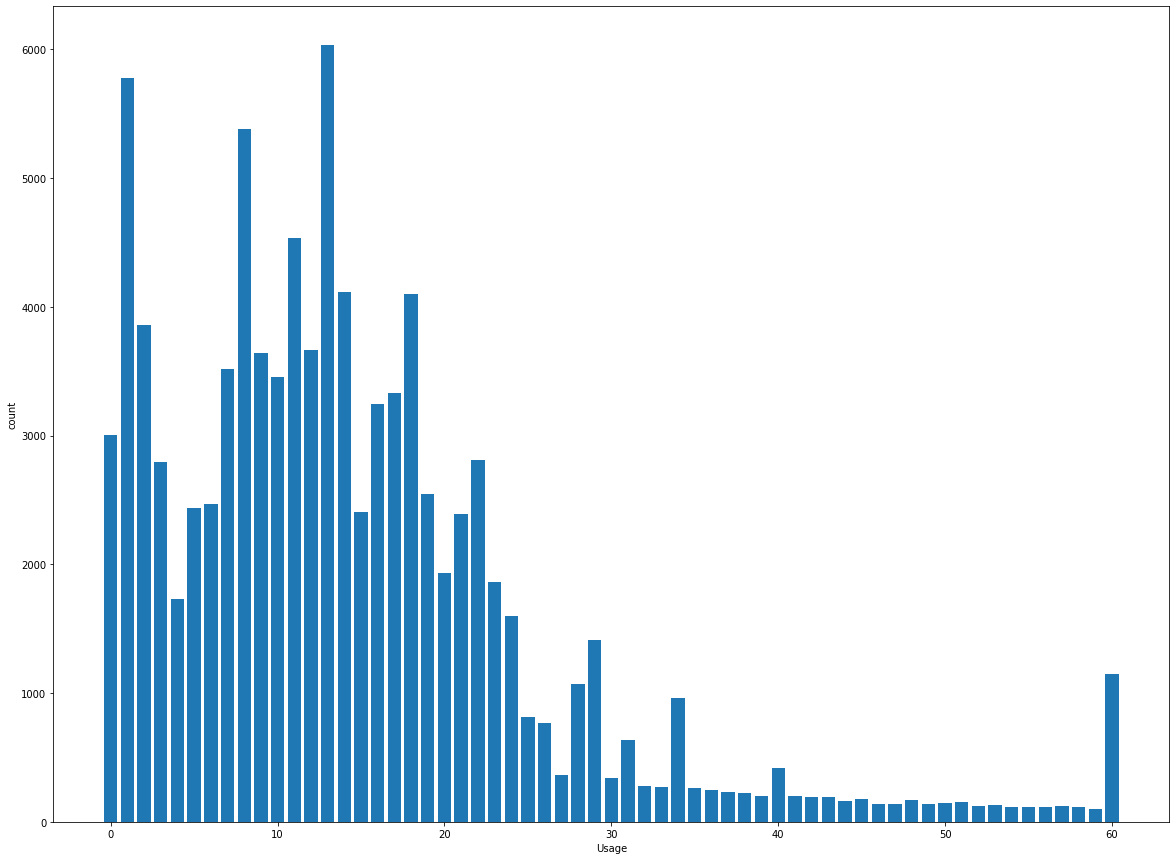

In [149]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(final_hour_usage_impute_mean)), return_counts=True)

#for number in range(len(u)): 
#    if u[number] > 60:
#        u[number] = 60
#    else:
#        u[number] = u[number]
        
plt.bar(u, c)
plt.xlabel('Usage')
plt.ylabel('count')
fig.savefig("Usage per hour AMDI.pdf", bbox_inches='tight')

In [150]:
result = pyreadr.read_r('hour_times_transposed')
hour_times_transposed = result[None]
del hour_times_transposed["user_id"]

In [151]:
print(hour_times_transposed.isnull().sum().sum())

60982


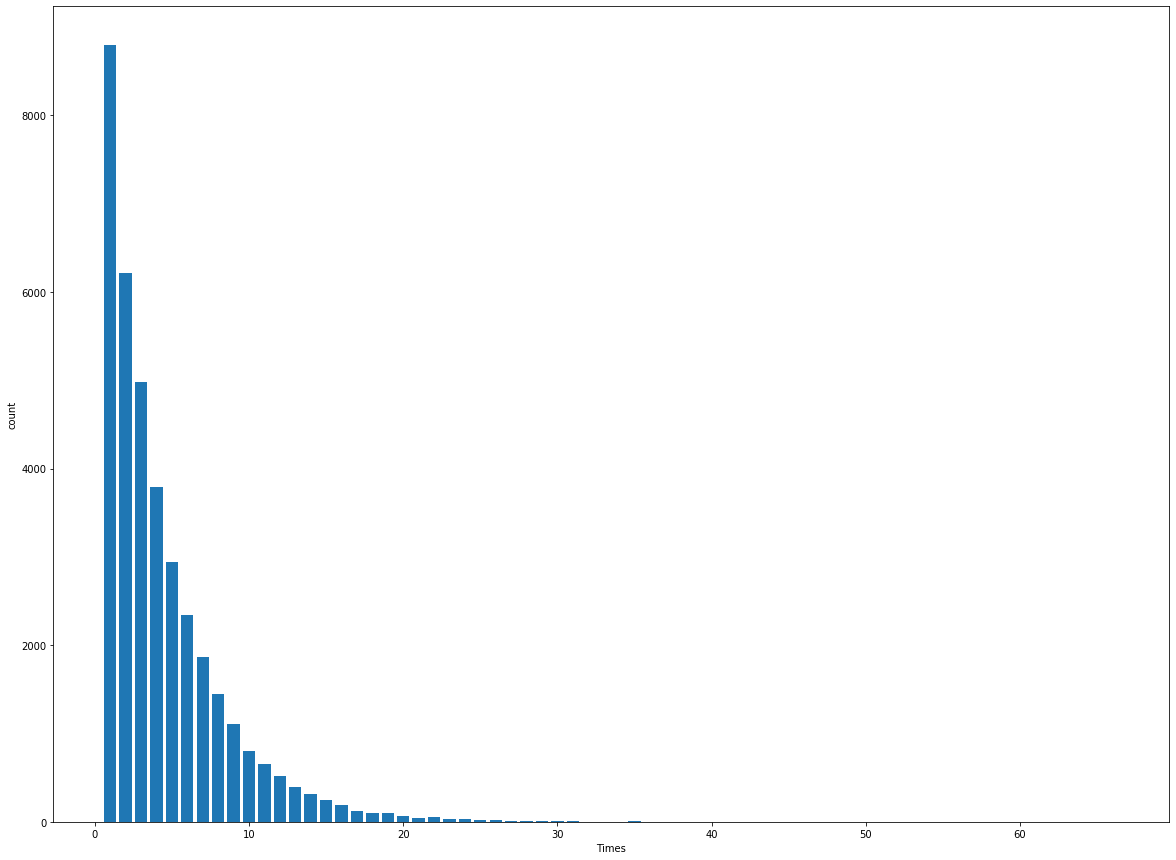

In [152]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(hour_times_transposed)), return_counts=True)
plt.bar(u, c)
plt.xlabel('Times')
plt.ylabel('count')
fig.savefig("Times per hour BMDI.pdf", bbox_inches='tight')

In [153]:
hour_times_transposed = hour_times_transposed.drop(null_rows.index)

In [154]:
hour_times_transposed_copy = hour_times_transposed.copy()

In [155]:
for col, value in hour_times_transposed_copy.items(): 
    if col.endswith('23') or col.endswith('00') or col.endswith('01') or col.endswith('02') or col.endswith('03') or col.endswith('04') or col.endswith('05') or col.endswith('06'):
        hour_times_transposed_copy[col] = hour_times_transposed_copy[col].fillna(0)

In [156]:
hour_times_transposed_mean = hour_times_transposed.apply(lambda x: x.fillna(int(x.mean())),axis=1)
first_column_mean = hour_times_transposed_mean.iloc[:,0]
last_column_mean = hour_times_transposed_mean.iloc[:,-1]

In [157]:
hour_times_transposed_copy.iloc[:,0] = first_column_mean
hour_times_transposed_copy.iloc[:,-1] = last_column_mean

In [158]:
hour_times_na = (hour_times_transposed_copy.isnull().sum(axis=1))

In [159]:
vals, counts = numpy.unique(hour_times_na, return_counts=True)
dic_hour_times_na = dict(zip(vals, counts))
##less than and equal to 148 values is 19 users

In [160]:
hour_times_few_na = hour_times_transposed_copy[hour_times_transposed_copy.isnull().sum(axis=1) <= 189]
hour_times_few_na_copy = hour_times_few_na.copy()

In [161]:
##make 10% na values per array
random.seed(113)
hour_times_few_na_matrix = numpy.zeros((130, hour_times_few_na_copy.shape[1]))

##print(hour_times_few_na_copy.shape)
for index, row in hour_times_few_na_copy.iterrows():
    row = numpy.array(row)
    for i in range(8):
        random_index = randrange(len(row))
        z = row[random_index]
        while numpy.isnan(z) or z == 0:
            random_index = randrange(len(row))
            z = row[random_index]   
        else:
            ##print(hour_times_few_na_copy.loc[index][random_index])
            hour_times_few_na_copy.loc[index][random_index] = numpy.nan
            hour_times_few_na_matrix[index,random_index] = z  
            ##print(index, random_index, hour_times_few_na_matrix[index, random_index])
            ##print(hour_times_few_na_copy.loc[index][random_index])

In [162]:
hour_times_impute_mean = hour_times_few_na_copy.apply(lambda x: x.fillna(x.mean()),axis=1)
hour_times_impute_median = hour_times_few_na_copy.apply(lambda x: x.fillna(x.median()),axis=1)
hour_times_impute_linear = hour_times_few_na_copy.interpolate(method = "linear", limit_direction = "both")
hour_times_impute_quadratic = hour_times_few_na_copy.interpolate(method = "quadratic", limit_direction = "both")
hour_times_impute_cubic = hour_times_few_na_copy.interpolate(method = "cubic", limit_direction = "both")

In [163]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_times_few_na_matrix)):
    if numpy.all(hour_times_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(hour_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_times_few_na_matrix[array,value]
                ##print(y)
                w = int(hour_times_impute_mean.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

808.0 166.0
974.0


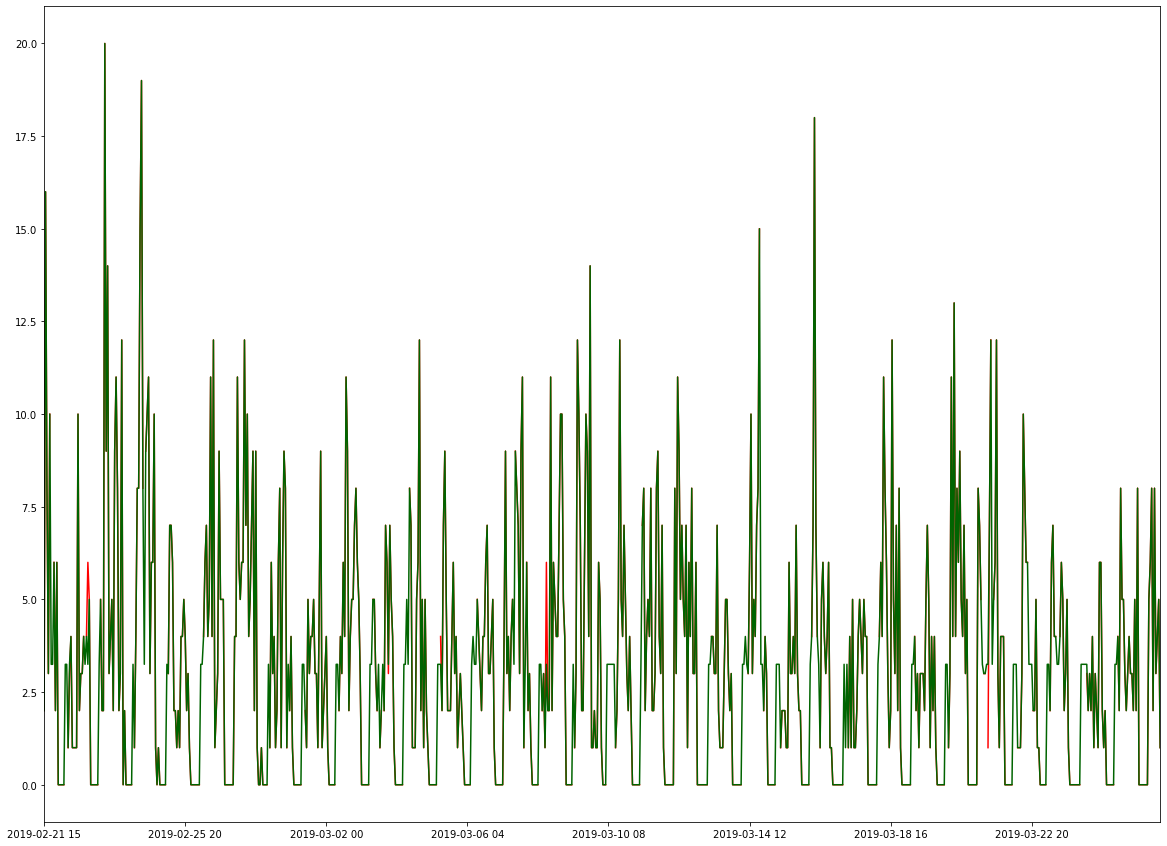

In [164]:
first = hour_times_few_na.iloc[0]
first_plot = first.plot.line(color = "Red")
second=hour_times_impute_mean.iloc[0]
second_plot = second.plot.line(color = "DarkGreen", ax = first_plot)
##second_plot.savefig("hour_times.pdf", bbox_inches='tight')

In [165]:
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = "20, 15"

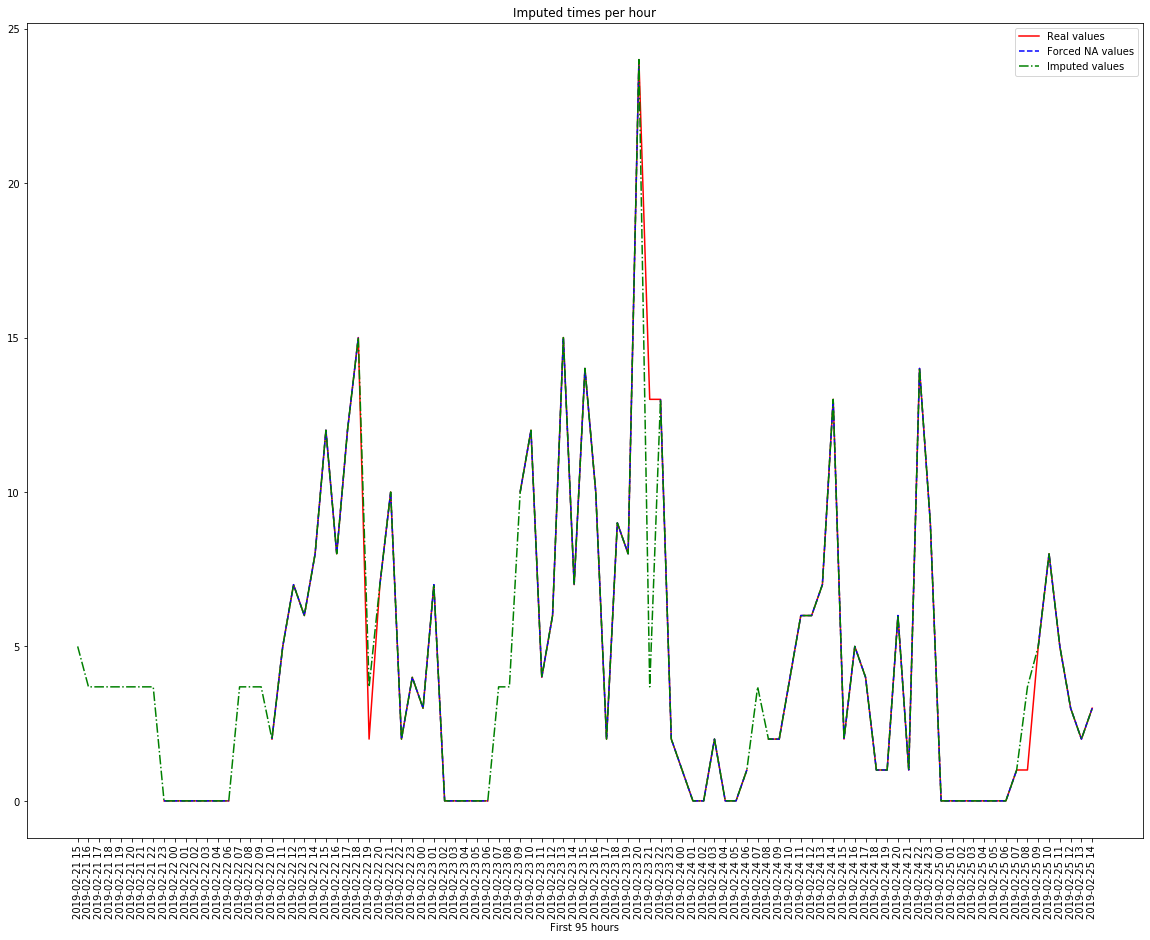

In [166]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
#ax.plot(hour_times_few_na.iloc[0])
plt.plot(hour_times_few_na.iloc[19, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(hour_times_few_na_copy.iloc[19, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(hour_times_impute_mean.iloc[19, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 hours"),
       title='Imputed times per hour');
fig.savefig("Times hour 19.pdf", bbox_inches='tight')

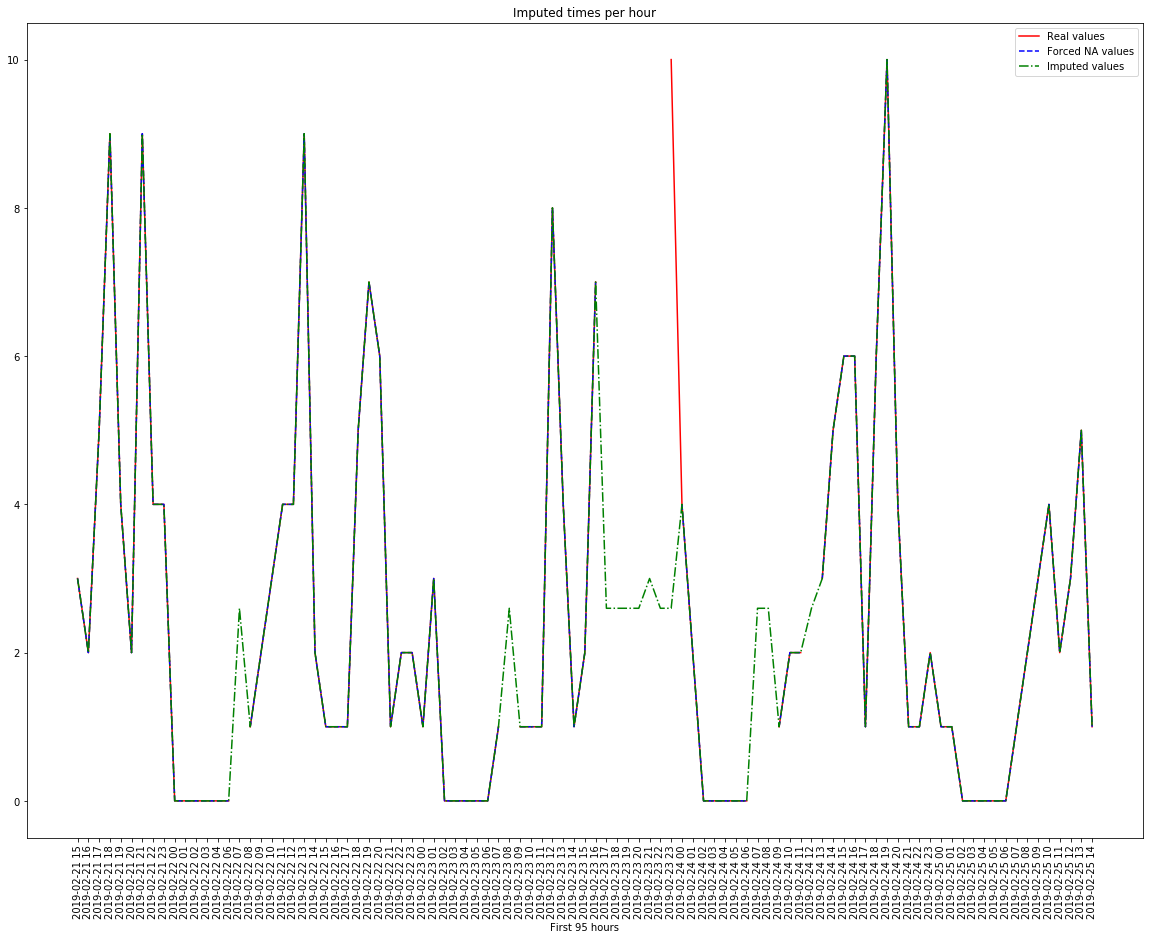

In [167]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(hour_times_few_na.iloc[0])
plt.plot(hour_times_few_na.iloc[14, 0:95], linestyle='-', color = "red", label = "Real values")  # solid
plt.plot(hour_times_few_na_copy.iloc[14, 0:95], linestyle='--', color = "blue", label = "Forced NA values") # dashed
plt.plot(hour_times_impute_mean.iloc[14, 0:95], linestyle='-.', color = "green", label = "Imputed values") # dashdot
plt.legend()
plt.xticks(rotation=90)
ax.set(xlabel=("First 95 hours"),
       title='Imputed times per hour');
fig.savefig("Times hour 14.pdf", bbox_inches='tight')

In [168]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_times_few_na_matrix)):
    if numpy.all(hour_times_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(hour_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_times_few_na_matrix[array,value]
                ##print(y)
                w = int(hour_times_impute_median.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

939.0 98.0
1037.0


In [169]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_times_few_na_matrix)):
    if numpy.all(hour_times_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(hour_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_times_few_na_matrix[array,value]
                ##print(y)
                w = int(hour_times_impute_linear.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

603.0 575.0
1178.0


In [170]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_times_few_na_matrix)):
    if numpy.all(hour_times_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(hour_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_times_few_na_matrix[array,value]
                ##print(y)
                w = hour_times_impute_quadratic.loc[array][value]
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

650.1972540614532 817.7043521658223
1467.9016062272756


In [171]:
#error on the difference between 
min_diff = 0
plus_diff = 0
for array in range(len(hour_times_few_na_matrix)):
    if numpy.all(hour_times_few_na_matrix[array] == 0):
        continue
    else:
        for i in numpy.nonzero(hour_times_few_na_matrix[array]):
            for value in i: 
                ##print(value)
                y = hour_times_few_na_matrix[array,value]
                ##print(y)
                w = (hour_times_impute_cubic.loc[array][value])
                ##print(w)
                diff = w - y
                ##print(diff)
                if diff > 0:
                    plus_diff += diff
                elif diff < 0:            
                    min_diff -= diff 
print(min_diff, plus_diff) 
print((min_diff + plus_diff))

701.7522294581491 872.0562690459151
1573.8084985040641


In [172]:
final_hour_times_impute_mean = hour_times_transposed.apply(lambda x: x.fillna(x.mean()),axis=1)

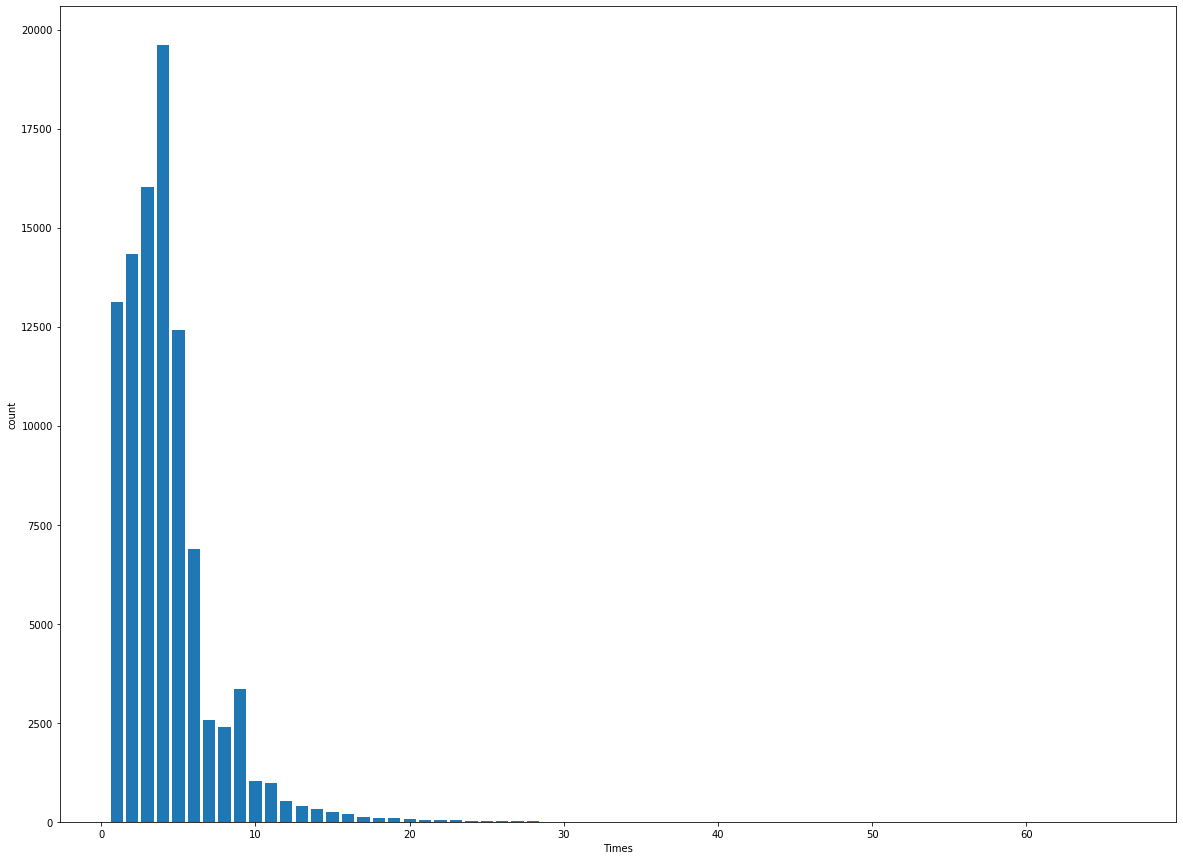

In [173]:
fig = plt.figure()
u, c = numpy.unique(numpy.array(round(final_hour_times_impute_mean)), return_counts=True)
plt.bar(u, c)
plt.xlabel('Times')
plt.ylabel('count')
fig.savefig("Times per hour AMDI.pdf", bbox_inches='tight')

In [174]:
##Euclidean distance & Cosine similarity stress median
S_euclidean_day = sklearn.metrics.pairwise.euclidean_distances(final_day_stress_impute_median)
S_cosine_day = sklearn.metrics.pairwise.cosine_similarity(final_day_stress_impute_median)

In [175]:
##from scipy.sparse import csr_matrix
##final_day_stress_impute_median2 = csr_matrix(final_day_stress_impute_median)
##final_day_stress_impute_median2 = final_day_stress_impute_median2.todense()
##final_day_stress_impute_median2 = final_day_stress_impute_median2.toarray()

In [176]:
S_euclidean_day = pandas.DataFrame(S_euclidean_day)
S_euclidean_day.to_csv("S_euclidean_day", encoding='utf-8', index = False, header = False)
S_cosine_day = pandas.DataFrame(S_cosine_day)
S_cosine_day.to_csv("S_cosine_day", encoding='utf-8', index = False, header = False)

In [177]:
##Euclidean distance & Cosine similarity calm median
C_euclidean_day = sklearn.metrics.pairwise.euclidean_distances(final_day_calm_impute_median)
C_cosine_day = sklearn.metrics.pairwise.cosine_similarity(final_day_calm_impute_median)

In [178]:
C_euclidean_day = pandas.DataFrame(C_euclidean_day)
C_euclidean_day.to_csv("C_euclidean_day", encoding='utf-8', index = False, header = False)
C_cosine_day = pandas.DataFrame(C_cosine_day)
C_cosine_day.to_csv("C_cosine_day", encoding='utf-8', index = False, header = False)

In [204]:
##Euclidean distance & Cosine similarity day usage mean 
U_euclidean_day = sklearn.metrics.pairwise.euclidean_distances(final_day_usage_impute_median)
U_cosine_day = sklearn.metrics.pairwise.cosine_similarity(final_day_usage_impute_median)

In [205]:
U_euclidean_day = pandas.DataFrame(U_euclidean_day)
U_euclidean_day.to_csv("U_euclidean_day", encoding='utf-8', index = False, header = False)
U_cosine_day = pandas.DataFrame(U_cosine_day)
U_cosine_day.to_csv("U_cosine_day", encoding='utf-8', index = False, header = False)

In [181]:
##Euclidean distance & Cosine similarity day times mean 
T_euclidean_day = sklearn.metrics.pairwise.euclidean_distances(final_day_times_impute_median)
T_cosine_day = sklearn.metrics.pairwise.cosine_similarity(final_day_times_impute_median)

In [182]:
T_euclidean_day = pandas.DataFrame(T_euclidean_day)
T_euclidean_day.to_csv("T_euclidean_day", encoding='utf-8', index = False, header = False)
T_cosine_day = pandas.DataFrame(T_cosine_day)
T_cosine_day.to_csv("T_cosine_day", encoding='utf-8', index = False, header = False)

In [183]:
##Euclidean distance & Cosine similarity part usage linear 
U_euclidean_part = sklearn.metrics.pairwise.euclidean_distances(final_part_usage_impute_mean)
U_cosine_part = sklearn.metrics.pairwise.cosine_similarity(final_part_usage_impute_mean)

In [184]:
U_euclidean_part = pandas.DataFrame(U_euclidean_part)
U_euclidean_part.to_csv("U_euclidean_part", encoding='utf-8', index = False, header = False)
U_cosine_part = pandas.DataFrame(U_cosine_part)
U_cosine_part.to_csv("U_cosine_part", encoding='utf-8', index = False, header = False)

In [185]:
##Euclidean distance & Cosine similarity part times mean 
T_euclidean_part = sklearn.metrics.pairwise.euclidean_distances(final_part_times_impute_median)
T_cosine_part = sklearn.metrics.pairwise.cosine_similarity(final_part_times_impute_median)

In [186]:
T_euclidean_part = pandas.DataFrame(T_euclidean_part)
T_euclidean_part.to_csv("T_euclidean_part", encoding='utf-8', index = False, header = False)
T_cosine_part = pandas.DataFrame(T_cosine_part)
T_cosine_part.to_csv("T_cosine_part", encoding='utf-8', index = False, header = False)

In [187]:
##Euclidean distance & Cosine similarity hour usage mean
U_euclidean_hour = sklearn.metrics.pairwise.euclidean_distances(final_hour_usage_impute_mean)
U_cosine_hour = sklearn.metrics.pairwise.cosine_similarity(final_hour_usage_impute_mean)

In [188]:
U_euclidean_hour = pandas.DataFrame(U_euclidean_hour)
U_euclidean_hour.to_csv("U_euclidean_hour", encoding='utf-8', index = False, header = False)
U_cosine_hour = pandas.DataFrame(U_cosine_hour)
U_cosine_hour.to_csv("U_cosine_hour", encoding='utf-8', index = False, header = False)

In [189]:
##Euclidean distance & Cosine similarity hour times linear 
T_euclidean_hour = sklearn.metrics.pairwise.euclidean_distances(final_hour_times_impute_mean)
T_cosine_hour = sklearn.metrics.pairwise.cosine_similarity(final_hour_times_impute_mean)

In [190]:
T_euclidean_hour = pandas.DataFrame(T_euclidean_hour)
T_euclidean_hour.to_csv("T_euclidean_hour", encoding='utf-8', index = False, header = False)
T_cosine_hour = pandas.DataFrame(T_cosine_hour)
T_cosine_hour.to_csv("T_cosine_hour", encoding='utf-8', index = False, header = False)

In [191]:
stress_cosine_null_rows = S_cosine_day[S_cosine_day.isnull().all(axis=0)]
stress_cosine_null_rows

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119


In [192]:
T_cosine_day

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,1.000000,0.929674,0.945479,0.839568,0.898906,0.929466,0.792031,0.914608,0.926796,0.925014,0.926863,0.805868,0.850812,0.825120,0.913177,0.889673,0.957064,0.896498,0.931759,0.909278,0.934413,0.774108,0.959541,0.922242,0.245768,0.938312,0.937288,0.927498,0.928017,0.900570,0.717193,0.924798,0.947376,0.951664,0.927642,0.923369,0.811744,0.932381,0.849808,0.931601,0.926675,0.770168,0.932369,0.907690,0.911005,0.924516,0.830121,0.592400,0.896759,0.837423,0.485400,0.911712,0.901941,0.939716,0.616876,0.897637,0.885983,0.878746,0.915989,0.944612,0.910161,0.872698,0.928404,0.930990,0.910972,0.949144,0.912042,0.935976,0.931236,0.910520,0.783766,0.944155,0.848934,0.923767,0.936529,0.871770,0.932176,0.935857,0.907373,0.849808,0.877289,0.819793,0.864862,0.921660,0.849994,0.843035,0.873005,0.861875,0.873309,0.910616,0.748454,0.922932,0.903129,0.925842,0.944296,0.919813,0.919047,0.925868,0.804119,0.927985,0.926026,0.886098,0.906303,0.894471,0.743261,0.888199,0.887511,0.928813,0.908314,0.934119,0.918696,0.862540,0.772138,0.890608,0.892649,0.947188,0.904728,0.911629,0.898579,0.777427
1,0.929674,1.000000,0.915022,0.847927,0.893347,0.935751,0.827458,0.883049,0.908488,0.912962,0.918751,0.767847,0.893962,0.832523,0.937276,0.856085,0.953829,0.856817,0.936579,0.901983,0.904493,0.802511,0.915394,0.906043,0.201930,0.904882,0.912234,0.913750,0.908578,0.910480,0.656982,0.912621,0.916241,0.934022,0.900126,0.905286,0.730862,0.901220,0.834094,0.948105,0.889044,0.752279,0.913864,0.899756,0.885311,0.857344,0.877003,0.587939,0.885912,0.785012,0.523814,0.852528,0.881344,0.906422,0.591797,0.917689,0.892295,0.899988,0.887192,0.892105,0.874485,0.905944,0.911323,0.911223,0.893255,0.926776,0.882131,0.912518,0.915201,0.905109,0.799564,0.931941,0.867054,0.902868,0.921075,0.881228,0.899852,0.902812,0.882402,0.834094,0.877828,0.851471,0.888048,0.913400,0.791440,0.838299,0.900722,0.864035,0.887505,0.901883,0.837636,0.932416,0.894499,0.930520,0.921718,0.913308,0.924592,0.905300,0.859039,0.906076,0.915880,0.905643,0.890580,0.844209,0.735548,0.891575,0.876318,0.916733,0.902637,0.921003,0.917123,0.822059,0.807622,0.872221,0.890259,0.923948,0.860767,0.900204,0.885984,0.793872
2,0.945479,0.915022,1.000000,0.891216,0.926771,0.936021,0.776537,0.905353,0.956460,0.962098,0.958665,0.822511,0.920523,0.879439,0.957929,0.924517,0.956684,0.909188,0.924663,0.948961,0.947894,0.835431,0.963193,0.916437,0.294428,0.993438,0.972567,0.959830,0.951876,0.951135,0.793913,0.949044,0.958636,0.989137,0.959680,0.961866,0.808294,0.953449,0.928200,0.968522,0.986891,0.871762,0.971029,0.951392,0.949941,0.953543,0.892121,0.649750,0.938254,0.896987,0.600722,0.901612,0.925551,0.994640,0.678280,0.929455,0.923003,0.934686,0.947938,0.943649,0.893100,0.928306,0.949175,0.957911,0.958030,0.954551,0.938293,0.952356,0.963355,0.943733,0.842716,0.970250,0.873849,0.962754,0.952906,0.923194,0.954724,0.951318,0.945368,0.928200,0.921543,0.884234,0.908072,0.937763,0.896765,0.905682,0.918969,0.874813,0.940821,0.963064,0.784239,0.965877,0.948955,0.945868,0.979393,0.956027,0.959526,0.962601,0.888591,0.955880,0.953683,0.930189,0.953420,0.913855,0.756708,0.933029,0.946672,0.962899,0.952589,0.952676,0.968262,0.888077,0.847230,0.929863,0.950474,0.979894,0.903559,0.958153,0.933128,0.807137
3,0.839568,0.847927,0.891216,1.000000,0.851331,0.882373,0.703683,0.812129,0.865431,0.870244,0.871519,0.719827,0.863425,0.780965,0.883173,0.836012,0.866514,0.765199,0.885148,0.925669,0.860366,0.697054,0.863785,0.833088,0.239966,0.887355,0.868882,0.834057,0.859919,0.847591,0.647020,0.864711,0.870815,0.881376,0.897640,0.862851,0.798700,0.864401,0.839073,0.850824,0.883446,0.807848,0.8